In [2]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

In [3]:
# 1. Membaca data dari berbagai file penjualan
files = [
    'dataset/Penjualan_Lazada_1.xlsx',
    'dataset/Penjualan_Lazada_2.xlsx',
    'dataset/Penjualan_Lazada_3.xlsx',
    'dataset/Penjualan_Retail_NG.xlsx',
    'dataset/Penjualan_Retail_RS.xlsx',
    'dataset/Penjualan_Retail_TA.xlsx',
    'dataset/Penjualan_Shopee_1.xlsx',
    'dataset/Penjualan_Shopee_2.xlsx',
    'dataset/Penjualan_Shopee_3.xlsx',
    'dataset/Penjualan_Tokopedia_1.xlsx',
    'dataset/Penjualan_Tokopedia_2.xlsx',
    'dataset/Penjualan_Tokopedia_3.xlsx'
]


In [4]:
# Kolom yang ingin diambil
desired_columns = ['Kode Nota', 'Tanggal', 'Deskripsi Brg', 'Jenis Barang', 'Jml']

# Menyimpan semua data penjualan ke dalam DataFrame
all_sales = []

# Looping untuk setiap file dan mengumpulkan data yang diinginkan
for file in files:
    try:
        # Membaca data dari file
        df = pd.read_excel(file)
        
        # Memeriksa kolom yang ada dalam DataFrame
        existing_columns = [col for col in desired_columns if col in df.columns]

        # Menyaring DataFrame untuk kolom yang ada
        df_filtered = df[existing_columns]

        # Tambahkan DataFrame yang difilter ke list
        all_sales.append(df_filtered)  

    except Exception as e:
        print(f"Error saat membaca file {file}: {e}")

# Menggabungkan semua DataFrame menjadi satu jika ada data
if all_sales:
    combined_df = pd.concat(all_sales, ignore_index=True)

    # Menghapus baris yang memiliki nilai null atau kosong
    combined_df.dropna(how='any', inplace=True)

    # Menyimpan hasil gabungan ke file Excel baru
    combined_output_path = 'dataset/Combined_Penjualan.xlsx'
    combined_df.to_excel(combined_output_path, index=False)
    print(f"Data gabungan telah disimpan di: {combined_output_path}")
else:
    print("Tidak ada data yang berhasil digabungkan.")

Data gabungan telah disimpan di: dataset/Combined_Penjualan.xlsx


In [5]:
# Menampilkan nama kolom
print("Nama Kolom:")
print(combined_df.columns.tolist())

# Menampilkan jumlah baris
print(f"\nJumlah Row: {len(combined_df)}")

# Menampilkan beberapa baris pertama dari DataFrame
print("\nBeberapa Baris Pertama dari DataFrame:")
print(combined_df.head())  # Menampilkan 5 baris pertama

Nama Kolom:
['Kode Nota', 'Tanggal', 'Deskripsi Brg', 'Jenis Barang', 'Jml']

Jumlah Row: 623798

Beberapa Baris Pertama dari DataFrame:
             Kode Nota    Tanggal                   Deskripsi Brg  \
0  C1/JK/23/01/0030027 2023-01-02  ACCU SPRAYER 12A (DOUBLE PUMP)   
1  C1/JK/23/01/0030028 2023-01-02         ACCU SPRAYER KANEDA 12A   
2  C1/JK/23/01/0030029 2023-01-02          ACCU SPRAYER KANEDA 8A   
3  C1/JK/23/01/0030030 2023-01-02          ACCU SPRAYER KANEDA 8A   
4  C1/JK/23/01/0030031 2023-01-02          ACCU SPRAYER KANEDA 8A   

        Jenis Barang Jml  
0  SPARE PART KANEDA   1  
1  SPARE PART KANEDA   1  
2  SPARE PART KANEDA   1  
3  SPARE PART KANEDA   1  
4  SPARE PART KANEDA   1  


In [ ]:
import pandas as pd

# Membaca data penjualan yang sudah digabung
file_penjualan = 'dataset/Combined_Penjualan.xlsx'
file_dead_stock = 'dataset/Laporan_Dead_Stok_2024.xlsx'
file_pembelian = 'dataset/Pembelian_2021_2024.xlsx'  

try:
    # Membaca data penjualan
    df_sales = pd.read_excel(file_penjualan)

    # Mengelompokkan data berdasarkan transaksi
    grouped_sales = df_sales.groupby('Kode Nota')['Deskripsi Brg'].apply(set).reset_index()

    # Barang yang pernah terjual bersama barang lain (Sold Together)
    sold_together = grouped_sales[grouped_sales['Deskripsi Brg'].str.len() > 1]
    sold_together_items = set()
    for items in sold_together['Deskripsi Brg']:
        sold_together_items.update(items)

    # Cari barang yang hanya pernah terjual sendiri di semua transaksinya (benar-benar Sold Alone)
    all_sold_items = df_sales.groupby('Deskripsi Brg')['Kode Nota'].nunique()
    single_sold_items = set(all_sold_items[all_sold_items == 1].index)  # Barang yang hanya muncul dalam 1 transaksi

    # Pastikan tidak termasuk barang yang juga pernah terjual bersama
    sold_alone_items = single_sold_items - sold_together_items

    # Membaca laporan dead stock
    df_dead_stock = pd.read_excel(file_dead_stock)
    not_sold_items = set(df_dead_stock[df_dead_stock['DS'] == '100']['Deskripsi Brg'].unique())

    # Tambahkan Produk dari File Pembelian
    df_pembelian = pd.read_excel(file_pembelian)
    purchased_products = set(df_pembelian['Deskripsi Brg'].unique())

    # Mengambil daftar produk dari penjualan (All Products)
    all_products = set(df_sales['Deskripsi Brg'].unique())

    # Gabungkan Produk dari Pembelian & Penjualan
    all_products.update(purchased_products)

    # Cari produk yang tidak masuk kategori mana pun (Unclassified)
    classified_products = sold_together_items | sold_alone_items | not_sold_items
    unclassified_products = all_products - classified_products  # Produk yang belum dikategorikan

    # Hapus produk Unclassified dari All Products
    all_products -= unclassified_products  # Langsung buang dari all_products

    # Cek apakah total kategori sudah benar
    total_calculated = len(sold_together_items) + len(sold_alone_items) + len(not_sold_items)
    print(f"Total All Products: {len(all_products)}")
    print(f"Sold Together: {len(sold_together_items)}")
    print(f"Sold Alone: {len(sold_alone_items)}")
    print(f"Not Sold: {len(not_sold_items)}")
    print(f"Total kategori gabungan: {total_calculated}")

    # Simpan hasil ke Excel
    output_path = 'dataset/Analisis_Produksi_Cleaned.xlsx'
    with pd.ExcelWriter(output_path) as writer:
        pd.DataFrame(list(all_products), columns=['Produk']).to_excel(writer, sheet_name='All Products', index=False)
        pd.DataFrame(list(sold_together_items), columns=['Produk']).to_excel(writer, sheet_name='Sold Together', index=False)
        pd.DataFrame(list(sold_alone_items), columns=['Produk']).to_excel(writer, sheet_name='Sold Alone', index=False)
        pd.DataFrame(list(not_sold_items), columns=['Produk']).to_excel(writer, sheet_name='Not Sold', index=False)

    print(f"Data analisis telah disimpan di: {output_path}")

except Exception as e:
    print(f"Terjadi kesalahan: {e}")


Total All Products: 27946
Sold Together: 25875
Sold Alone: 2011
Not Sold: 1619
Total kategori gabungan: 29505
Data analisis telah disimpan di: dataset/Analisis_Produksi_Cleaned.xlsx


## RFM

In [14]:
import pandas as pd

# Load the Excel file
file_path = "dataset/Combined_Penjualan.xlsx"
xls = pd.ExcelFile(file_path)

# Read the sheet into a DataFrame
df = pd.read_excel(xls, sheet_name="Sheet1")

# Convert 'Tanggal' to datetime format
df["Tanggal"] = pd.to_datetime(df["Tanggal"])

df["Jml"] = df["Jml"].astype(str)  # Ubah ke string untuk konsistensi
df["Jml"] = df["Jml"].str.strip()  # Hapus spasi
df["Jml"] = df["Jml"].str.replace(",", ".", regex=False)  # Ganti koma dengan titik
df["Jml"] = df["Jml"].str.replace(r"[^0-9.]", "", regex=True)  # Hapus karakter selain angka dan titik
df["Jml"] = pd.to_numeric(df["Jml"], errors="coerce")  # Konversi ke float

# Define the reference date as the most recent transaction date
reference_date = df["Tanggal"].max()

# Calculate RFM metrics for each product
rfm = df.groupby("Deskripsi Brg").agg(
    Recency=("Tanggal", lambda x: (reference_date - x.max()).days),  # Days since last purchase
    Frequency=("Kode Nota", "nunique"),  # Number of unique transactions
    Monetary=("Jml", "sum")  # Total quantity sold
).reset_index()

# Define scoring functions
def score_recency(days):
    if days == 0:
        return 5
    elif 1 <= days <= 7:
        return 4
    elif 8 <= days <= 30:
        return 3
    elif 31 <= days <= 90:
        return 2
    else:
        return 1

def score_frequency(freq):
    if freq >= 1200:
        return 5
    elif freq >= 600:
        return 4
    elif freq >= 300:
        return 3
    elif freq >= 120:
        return 2
    else:
        return 1

def score_monetary(amount):
    if amount >= 6000:
        return 5
    elif amount >= 3000:
        return 4
    elif amount >= 1200:
        return 3
    elif amount >= 120:
        return 2
    else:
        return 1

# Apply scoring
rfm["R_Score"] = rfm["Recency"].apply(score_recency)
rfm["F_Score"] = rfm["Frequency"].apply(score_frequency)
rfm["M_Score"] = rfm["Monetary"].apply(score_monetary)

# Function to categorize products
def categorize_product(row):
    R, F, M = row["R_Score"], row["F_Score"], row["M_Score"]
    
    if R > 3 and F > 4:
        return "Barang Naik Daun (Trending Products)"
    elif R > 3 and F > 3 : 
        return "Barang Fast Moving" 
    elif R > 4 and F < 3 :
        return "Barang Loyal (Loyal Products)"
    elif R > 4 and 3 < F < 5:
        return "Barang Potensial (Potential Products)" 
    elif 1 < F < 5 and M < 4:
        return "Barang Sedang (Average Products)"
    elif R > 2 and F <= 2:
        return "Barang Stagnan (Stagnant Products)" 
    elif F < 2 and M < 2:
        return "Deadstock (Non-Moving Products)" #byk karena yg di data itu dari stok ini dari penjualan
    elif M > 1:
        return "Barang Habis Pakai" #barang yang hrs diganti cth : mata bor || skali beli quantity besar || F pasti lebi kecil dari M
    else:
        return "Uncategorized"

# Apply categorization
rfm["Category"] = rfm.apply(categorize_product, axis=1)

# Save results to a new Excel file
output_file = "dataset/RFM_Results.xlsx"
rfm.to_excel(output_file, index=False)

print("RFM segmentation completed. Results saved to", output_file)


RFM segmentation completed. Results saved to dataset/RFM_Results.xlsx


## RFM SHopee

In [1]:
import pandas as pd

# Load the Excel file
file_path = "dataset/Penjualan_Shopee.xlsx"
xls = pd.ExcelFile(file_path)

# Read the sheet into a DataFrame
df = pd.read_excel(xls, sheet_name="Laporan Penjualan Shopee")

# Convert 'Tanggal' to datetime format
df["Tanggal"] = pd.to_datetime(df["Tanggal"])

df["Jml"] = df["Jml"].astype(str)  # Ubah ke string untuk konsistensi
df["Jml"] = df["Jml"].str.strip()  # Hapus spasi
df["Jml"] = df["Jml"].str.replace(",", ".", regex=False)  # Ganti koma dengan titik
df["Jml"] = df["Jml"].str.replace(r"[^0-9.]", "", regex=True)  # Hapus karakter selain angka dan titik
df["Jml"] = pd.to_numeric(df["Jml"], errors="coerce")  # Konversi ke float

# Define the reference date as the most recent transaction date
reference_date = df["Tanggal"].max()

# Calculate RFM metrics for each product
rfm = df.groupby("Deskripsi Brg").agg(
    Recency=("Tanggal", lambda x: (reference_date - x.max()).days),  # Days since last purchase
    Frequency=("Kode Nota", "nunique"),  # Number of unique transactions
    Monetary=("Jml", "sum")  # Total quantity sold
).reset_index()

# Define scoring functions
def score_recency(days):
    if days == 0:
        return 5
    elif 1 <= days <= 7:
        return 4
    elif 8 <= days <= 30:
        return 3
    elif 31 <= days <= 90:
        return 2
    else:
        return 1

def score_frequency(freq):
    if freq >= 1200:
        return 5
    elif freq >= 600:
        return 4
    elif freq >= 300:
        return 3
    elif freq >= 120:
        return 2
    else:
        return 1

def score_monetary(amount):
    if amount >= 6000:
        return 5
    elif amount >= 3000:
        return 4
    elif amount >= 1200:
        return 3
    elif amount >= 120:
        return 2
    else:
        return 1

# Apply scoring
rfm["R_Score"] = rfm["Recency"].apply(score_recency)
rfm["F_Score"] = rfm["Frequency"].apply(score_frequency)
rfm["M_Score"] = rfm["Monetary"].apply(score_monetary)

# Function to categorize products
def categorize_product(row):
    R, F, M = row["R_Score"], row["F_Score"], row["M_Score"]
    
    if R > 3 and F > 4:
        return "Barang Naik Daun (Trending Products)"
    elif R > 3 and F > 3 : 
        return "Barang Fast Moving" 
    elif R > 4 and F < 3 :
        return "Barang Loyal (Loyal Products)"
    elif R > 4 and 3 < F < 5:
        return "Barang Potensial (Potential Products)" 
    elif 1 < F < 5 and M < 4:
        return "Barang Sedang (Average Products)"
    elif R > 2 and F <= 2:
        return "Barang Stagnan (Stagnant Products)" 
    elif F < 2 and M < 2:
        return "Deadstock (Non-Moving Products)" #byk karena yg di data itu dari stok ini dari penjualan
    elif M > 1:
        return "Barang Habis Pakai" #barang yang hrs diganti cth : mata bor || skali beli quantity besar || F pasti lebi kecil dari M
    else:
        return "Uncategorized"

# Apply categorization
rfm["Category"] = rfm.apply(categorize_product, axis=1)

# Save results to a new Excel file
output_file = "dataset/rfm_shopee.xlsx"
rfm.to_excel(output_file, index=False)

print("RFM segmentation completed. Results saved to", output_file)


RFM segmentation completed. Results saved to dataset/rfm_shopee.xlsx


## RFM Tokopedia

In [5]:
import pandas as pd

# Load the Excel file
file_path = "dataset/Penjualan_Tokopedia.xlsx"
xls = pd.ExcelFile(file_path)

# Read the sheet into a DataFrame
df = pd.read_excel(xls, sheet_name="Laporan Penjualan Tokopedia")

# Convert 'Tanggal' to datetime format
df["Tanggal"] = pd.to_datetime(df["Tanggal"])

df["Jml"] = df["Jml"].astype(str)  # Ubah ke string untuk konsistensi
df["Jml"] = df["Jml"].str.strip()  # Hapus spasi
df["Jml"] = df["Jml"].str.replace(",", ".", regex=False)  # Ganti koma dengan titik
df["Jml"] = df["Jml"].str.replace(r"[^0-9.]", "", regex=True)  # Hapus karakter selain angka dan titik
df["Jml"] = pd.to_numeric(df["Jml"], errors="coerce")  # Konversi ke float

# Define the reference date as the most recent transaction date
reference_date = df["Tanggal"].max()

# Calculate RFM metrics for each product
rfm = df.groupby("Deskripsi Brg").agg(
    Recency=("Tanggal", lambda x: (reference_date - x.max()).days),  # Days since last purchase
    Frequency=("Kode Nota", "nunique"),  # Number of unique transactions
    Monetary=("Jml", "sum")  # Total quantity sold
).reset_index()

# Define scoring functions
def score_recency(days):
    if days == 0:
        return 5
    elif 1 <= days <= 7:
        return 4
    elif 8 <= days <= 30:
        return 3
    elif 31 <= days <= 90:
        return 2
    else:
        return 1

def score_frequency(freq):
    if freq >= 1200:
        return 5
    elif freq >= 600:
        return 4
    elif freq >= 300:
        return 3
    elif freq >= 120:
        return 2
    else:
        return 1

def score_monetary(amount):
    if amount >= 6000:
        return 5
    elif amount >= 3000:
        return 4
    elif amount >= 1200:
        return 3
    elif amount >= 120:
        return 2
    else:
        return 1

# Apply scoring
rfm["R_Score"] = rfm["Recency"].apply(score_recency)
rfm["F_Score"] = rfm["Frequency"].apply(score_frequency)
rfm["M_Score"] = rfm["Monetary"].apply(score_monetary)

# Function to categorize products
def categorize_product(row):
    R, F, M = row["R_Score"], row["F_Score"], row["M_Score"]
    
    if R > 3 and F > 4:
        return "Barang Naik Daun (Trending Products)"
    elif R > 3 and F > 3 : 
        return "Barang Fast Moving" 
    elif R > 4 and F < 3 :
        return "Barang Loyal (Loyal Products)"
    elif R > 4 and 3 < F < 5:
        return "Barang Potensial (Potential Products)" 
    elif 1 < F < 5 and M < 4:
        return "Barang Sedang (Average Products)"
    elif R > 2 and F <= 2:
        return "Barang Stagnan (Stagnant Products)" 
    elif F < 2 and M < 2:
        return "Deadstock (Non-Moving Products)" #byk karena yg di data itu dari stok ini dari penjualan
    elif M > 1:
        return "Barang Habis Pakai" #barang yang hrs diganti cth : mata bor || skali beli quantity besar || F pasti lebi kecil dari M
    else:
        return "Uncategorized"

# Apply categorization
rfm["Category"] = rfm.apply(categorize_product, axis=1)

# Save results to a new Excel file
output_file = "dataset/rfm_tokopedia.xlsx"
rfm.to_excel(output_file, index=False)

print("RFM segmentation completed. Results saved to", output_file)


RFM segmentation completed. Results saved to dataset/rfm_tokopedia.xlsx


## RFM Lazada

In [6]:
import pandas as pd

# Load the Excel file
file_path = "dataset/Penjualan_Lazada.xlsx"
xls = pd.ExcelFile(file_path)

# Read the sheet into a DataFrame
df = pd.read_excel(xls, sheet_name="Laporan Penjualan Lazada")

# Convert 'Tanggal' to datetime format
df["Tanggal"] = pd.to_datetime(df["Tanggal"])

df["Jml"] = df["Jml"].astype(str)  # Ubah ke string untuk konsistensi
df["Jml"] = df["Jml"].str.strip()  # Hapus spasi
df["Jml"] = df["Jml"].str.replace(",", ".", regex=False)  # Ganti koma dengan titik
df["Jml"] = df["Jml"].str.replace(r"[^0-9.]", "", regex=True)  # Hapus karakter selain angka dan titik
df["Jml"] = pd.to_numeric(df["Jml"], errors="coerce")  # Konversi ke float

# Define the reference date as the most recent transaction date
reference_date = df["Tanggal"].max()

# Calculate RFM metrics for each product
rfm = df.groupby("Deskripsi Brg").agg(
    Recency=("Tanggal", lambda x: (reference_date - x.max()).days),  # Days since last purchase
    Frequency=("Kode Nota", "nunique"),  # Number of unique transactions
    Monetary=("Jml", "sum")  # Total quantity sold
).reset_index()

# Define scoring functions
def score_recency(days):
    if days == 0:
        return 5
    elif 1 <= days <= 7:
        return 4
    elif 8 <= days <= 30:
        return 3
    elif 31 <= days <= 90:
        return 2
    else:
        return 1

def score_frequency(freq):
    if freq >= 1200:
        return 5
    elif freq >= 600:
        return 4
    elif freq >= 300:
        return 3
    elif freq >= 120:
        return 2
    else:
        return 1

def score_monetary(amount):
    if amount >= 6000:
        return 5
    elif amount >= 3000:
        return 4
    elif amount >= 1200:
        return 3
    elif amount >= 120:
        return 2
    else:
        return 1

# Apply scoring
rfm["R_Score"] = rfm["Recency"].apply(score_recency)
rfm["F_Score"] = rfm["Frequency"].apply(score_frequency)
rfm["M_Score"] = rfm["Monetary"].apply(score_monetary)

# Function to categorize products
def categorize_product(row):
    R, F, M = row["R_Score"], row["F_Score"], row["M_Score"]
    
    if R > 3 and F > 4:
        return "Barang Naik Daun (Trending Products)"
    elif R > 3 and F > 3 : 
        return "Barang Fast Moving" 
    elif R > 4 and F < 3 :
        return "Barang Loyal (Loyal Products)"
    elif R > 4 and 3 < F < 5:
        return "Barang Potensial (Potential Products)" 
    elif 1 < F < 5 and M < 4:
        return "Barang Sedang (Average Products)"
    elif R > 2 and F <= 2:
        return "Barang Stagnan (Stagnant Products)" 
    elif F < 2 and M < 2:
        return "Deadstock (Non-Moving Products)" #byk karena yg di data itu dari stok ini dari penjualan
    elif M > 1:
        return "Barang Habis Pakai" #barang yang hrs diganti cth : mata bor || skali beli quantity besar || F pasti lebi kecil dari M
    else:
        return "Uncategorized"

# Apply categorization
rfm["Category"] = rfm.apply(categorize_product, axis=1)

# Save results to a new Excel file
output_file = "dataset/rfm_lazada.xlsx"
rfm.to_excel(output_file, index=False)

print("RFM segmentation completed. Results saved to", output_file)


RFM segmentation completed. Results saved to dataset/rfm_lazada.xlsx


## RFM & BUNDLING CATEGORY MATCHING

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load file Analisis_Produksi_Cleaned.xlsx
file_path = "dataset/Analisis_Produksi_Cleaned.xlsx"

# Membaca data dari sheet "Sold Together" dan "Not Sold"
df_sold_together = pd.read_excel(file_path, sheet_name="Sold Together")
df_not_sold = pd.read_excel(file_path, sheet_name="Not Sold")

# Pastikan kolom yang digunakan ada dalam DataFrame
if "Produk" not in df_sold_together.columns or "Produk" not in df_not_sold.columns:
    raise ValueError("Kolom 'Produk' tidak ditemukan dalam salah satu sheet!")

# Ambil daftar produk
sold_together_products = df_sold_together["Produk"].astype(str).tolist()
not_sold_products = df_not_sold["Produk"].astype(str).tolist()

# Gabungkan semua produk untuk vektorisasi
all_products = sold_together_products + not_sold_products

# Menggunakan TF-IDF untuk vektorisasi deskripsi produk
vectorizer = TfidfVectorizer()
product_vectors = vectorizer.fit_transform(all_products)

# Hitung Cosine Similarity sebagai pendekatan ke Jaccard
similarity_matrix = cosine_similarity(product_vectors)

# Pisahkan kembali untuk melihat kemiripan antara Sold Together dan Not Sold
similarity_df = pd.DataFrame(similarity_matrix[:len(sold_together_products), len(sold_together_products):],
                             index=sold_together_products, columns=not_sold_products)

# Filter similarity > 0.5
threshold = 0.5
filtered_pairs = []
for sold_product in similarity_df.index:
    for not_sold_product in similarity_df.columns:
        score = similarity_df.at[sold_product, not_sold_product]
        if score > threshold:
            filtered_pairs.append((sold_product, not_sold_product, score))

# Buat DataFrame untuk hasil yang difilter
filtered_df = pd.DataFrame(filtered_pairs, columns=["Sold Together Product", "Not Sold Product", "Similarity Score"])

# Simpan hasil ke file Excel dengan dua sheet
output_file = "dataset/Cosine_Similarity.xlsx"
with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    similarity_df.to_excel(writer, sheet_name="All Similarities")
    filtered_df.to_excel(writer, sheet_name="Filtered (>0.5)", index=False)

print(f"Hasil telah disimpan di {output_file} dengan threshold > 0.5 di sheet 'Filtered (>0.5)'.")


Hasil telah disimpan di dataset/Cosine_Similarity.xlsx dengan threshold > 0.5 di sheet 'Filtered (>0.5)'.


## BUNDLING DEADSTOCK

## ALL

In [8]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# 1. Initialize Spark Session
spark = SparkSession.builder.appName("FPGrowth_Deadstock_Bundling").getOrCreate()

# 2. Load Excel Files
combined_penjualan_path = "dataset/Combined_Penjualan.xlsx"
rfm_path = "dataset/RFM_Results.xlsx"

df_penjualan = pd.read_excel(combined_penjualan_path)
df_rfm = pd.read_excel(rfm_path)

# 3. Filter transactions with more than one product
temp = df_penjualan.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = temp[temp["count"] > 1]["Kode Nota"]
df_penjualan_filtered = df_penjualan[df_penjualan["Kode Nota"].isin(valid_nota)]

# 4. Merge with RFM for category information
rfm_mapping = df_rfm[["Deskripsi Brg", "Category"]]
df_joined = df_penjualan_filtered.merge(rfm_mapping, on="Deskripsi Brg", how="left")

# 5. Filter transactions containing at least one deadstock product
def filter_deadstock(group):
    return (group["Category"] == "Deadstock (Non-Moving Products)").any()

grouped = df_joined.groupby("Kode Nota")
filtered_groups = grouped.filter(filter_deadstock)
filtered_groups = filtered_groups.dropna(subset=["Deskripsi Brg"])
grouped_items = filtered_groups.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
grouped_items["Deskripsi Brg"] = grouped_items["Deskripsi Brg"].apply(list)

# 6. Convert to PySpark DataFrame
df_spark = spark.createDataFrame(grouped_items.rename(columns={"Deskripsi Brg": "items"}))

# 7. Define parameters for FP-Growth
support_values = [0.001, 0.0005, 0.0004, 0.0003]
confidence_values = [0.5, 0.3, 0.1]
output_file = "dataset/FP_Growth_Deadstock_Final.xlsx"

# 8. Create RFM dictionary for category mapping
rfm_dict = df_rfm.set_index("Deskripsi Brg")["Category"].to_dict()

# 9. Collect all rules for status determination
all_rules = []
for min_support in support_values:
    for min_conf in confidence_values:
        print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")

        # Run FP-Growth
        fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
        model = fp_growth.fit(df_spark)

        # Get Association Rules
        df_rules = model.associationRules.toPandas()
        df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
        if not df_rules.empty:
            # Filter rules to ensure they contain deadstock
            def contains_deadstock_both(antecedent, consequent):
                antecedent_items = eval(antecedent) if isinstance(antecedent, str) else antecedent
                consequent_items = eval(consequent) if isinstance(consequent, str) else consequent
                all_items = antecedent_items + consequent_items
                return any(rfm_dict.get(item, "") == "Deadstock (Non-Moving Products)" for item in all_items)

            df_rules_filtered = df_rules[df_rules.apply(lambda x: contains_deadstock_both(x["antecedent"], x["consequent"]), axis=1)].copy()

            # Map categories to rules
            def map_category(item_list):
                items = eval(item_list) if isinstance(item_list, str) else item_list
                return [rfm_dict.get(item, "Unknown") for item in items]

            df_rules_filtered["Antecedent_Category"] = df_rules_filtered["antecedent"].apply(map_category)
            df_rules_filtered["Consequent_Category"] = df_rules_filtered["consequent"].apply(map_category)

            all_rules.append(df_rules_filtered)

# Combine all rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)

# 10. Determine "new" and "existing" status
def rule_to_tuple(row):
    antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
    consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
    antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
    consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
    return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

seen_rules = set()

def determine_status(row):
    rule = rule_to_tuple(row)
    if rule not in seen_rules:
        seen_rules.add(rule)
        return 'new'
    return 'existing'

all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)
all_rules_df['validity'] = pd.NA

# Reorder columns for clarity
all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'Antecedent_Category', 'Consequent_Category', 'status', 'validity']]

# 11. Write results to Excel
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write individual rule sheets
    for min_support in support_values:
        for min_conf in confidence_values:
            sheet_name_rules = f"Sup{min_support}_Conf{min_conf}_Rules"[:31]
            df_sheet = all_rules_df[all_rules_df['sheet'] == f"Sup{min_support}_Conf{min_conf}_Rules"]
            if not df_sheet.empty:
                df_sheet.drop(columns=['status', 'validity']).to_excel(writer, sheet_name=sheet_name_rules, index=False)

    # Write combined rules with status for owner evaluation
    all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)

# Print summary
print(f"✅ All bundling results saved to: {output_file}")
print(f"Total unique rules: {len(seen_rules)}")
print(f"Rules marked as 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
print(f"Rules marked as 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
print("All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file")

# 12. Stop Spark session
spark.stop()

Running FP-Growth with minSupport=0.001, minConfidence=0.5
Running FP-Growth with minSupport=0.001, minConfidence=0.3
Running FP-Growth with minSupport=0.001, minConfidence=0.1
Running FP-Growth with minSupport=0.0005, minConfidence=0.5
Running FP-Growth with minSupport=0.0005, minConfidence=0.3
Running FP-Growth with minSupport=0.0005, minConfidence=0.1
Running FP-Growth with minSupport=0.0004, minConfidence=0.5
Running FP-Growth with minSupport=0.0004, minConfidence=0.3
Running FP-Growth with minSupport=0.0004, minConfidence=0.1
Running FP-Growth with minSupport=0.0003, minConfidence=0.5
Running FP-Growth with minSupport=0.0003, minConfidence=0.3
Running FP-Growth with minSupport=0.0003, minConfidence=0.1
✅ All bundling results saved to: dataset/FP_Growth_Deadstock_Final.xlsx
Total unique rules: 207
Rules marked as 'new': 207
Rules marked as 'existing': 712
All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file


## SHOPEE

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# 1. Initialize Spark Session
spark = SparkSession.builder.appName("FPGrowth_Shopee_Deadstock_Bundling").getOrCreate()

# 2. Load Excel Files
shopee_path = "dataset/Penjualan_Shopee.xlsx"
rfm_path = "dataset/RFM_Results.xlsx"

df_shopee = pd.read_excel(shopee_path)
df_rfm = pd.read_excel(rfm_path)

# 3. Filter transactions with more than one product
temp = df_shopee.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = temp[temp["count"] > 1]["Kode Nota"]
df_shopee_filtered = df_shopee[df_shopee["Kode Nota"].isin(valid_nota)]

# 4. Merge with RFM for category information
rfm_mapping = df_rfm[["Deskripsi Brg", "Category"]]
df_joined = df_shopee_filtered.merge(rfm_mapping, on="Deskripsi Brg", how="left")

# 5. Filter transactions containing at least one deadstock product
def filter_deadstock(group):
    return (group["Category"] == "Deadstock (Non-Moving Products)").any()

grouped = df_joined.groupby("Kode Nota")
filtered_groups = grouped.filter(filter_deadstock)
filtered_groups = filtered_groups.dropna(subset=["Deskripsi Brg"])
grouped_items = filtered_groups.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
grouped_items["Deskripsi Brg"] = grouped_items["Deskripsi Brg"].apply(list)

# 6. Convert to PySpark DataFrame
df_spark = spark.createDataFrame(grouped_items.rename(columns={"Deskripsi Brg": "items"}))

# 7. Define parameters for FP-Growth
support_values = [0.01, 0.005, 0.003]
confidence_values = [0.8, 0.5, 0.1]
output_file = "dataset/FP_Growth_Shopee_Deadstock_Final.xlsx"

# 8. Create RFM dictionary for category mapping
rfm_dict = df_rfm.set_index("Deskripsi Brg")["Category"].to_dict()

# 9. Collect all rules for status determination
all_rules = []
for min_support in support_values:
    for min_conf in confidence_values:
        print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")

        # Run FP-Growth
        fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
        model = fp_growth.fit(df_spark)

        # Get Association Rules
        df_rules = model.associationRules.toPandas()
        df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
        if not df_rules.empty:
            # Filter rules to ensure they contain deadstock
            def contains_deadstock_both(antecedent, consequent):
                antecedent_items = eval(antecedent) if isinstance(antecedent, str) else antecedent
                consequent_items = eval(consequent) if isinstance(consequent, str) else consequent
                all_items = antecedent_items + consequent_items
                return any(rfm_dict.get(item, "") == "Deadstock (Non-Moving Products)" for item in all_items)

            df_rules_filtered = df_rules[df_rules.apply(lambda x: contains_deadstock_both(x["antecedent"], x["consequent"]), axis=1)].copy()

            # Map categories to rules
            def map_category(item_list):
                items = eval(item_list) if isinstance(item_list, str) else item_list
                return [rfm_dict.get(item, "Unknown") for item in items]

            df_rules_filtered["Antecedent_Category"] = df_rules_filtered["antecedent"].apply(map_category)
            df_rules_filtered["Consequent_Category"] = df_rules_filtered["consequent"].apply(map_category)

            all_rules.append(df_rules_filtered)

# Combine all rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)

# 10. Determine "new" and "existing" status
def rule_to_tuple(row):
    antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
    consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
    antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
    consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
    return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

seen_rules = set()

def determine_status(row):
    rule = rule_to_tuple(row)
    if rule not in seen_rules:
        seen_rules.add(rule)
        return 'new'
    return 'existing'

all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)
all_rules_df['validity'] = pd.NA

# Reorder columns for clarity
all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'Antecedent_Category', 'Consequent_Category', 'status', 'validity']]

# 11. Write results to Excel
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write individual rule sheets
    for min_support in support_values:
        for min_conf in confidence_values:
            sheet_name_rules = f"Sup{min_support}_Conf{min_conf}_Rules"[:31]
            df_sheet = all_rules_df[all_rules_df['sheet'] == f"Sup{min_support}_Conf{min_conf}_Rules"]
            if not df_sheet.empty:
                df_sheet.drop(columns=['status', 'validity']).to_excel(writer, sheet_name=sheet_name_rules, index=False)

    # Write combined rules with status for owner evaluation
    all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)

# Print summary
print(f"✅ All bundling results saved to: {output_file}")
print(f"Total unique rules: {len(seen_rules)}")
print(f"Rules marked as 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
print(f"Rules marked as 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
print("All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file")

# 12. Stop Spark session
spark.stop()

Running FP-Growth with minSupport=0.01, minConfidence=0.8
Running FP-Growth with minSupport=0.01, minConfidence=0.5
Running FP-Growth with minSupport=0.01, minConfidence=0.1
Running FP-Growth with minSupport=0.005, minConfidence=0.8
Running FP-Growth with minSupport=0.005, minConfidence=0.5
Running FP-Growth with minSupport=0.005, minConfidence=0.1
Running FP-Growth with minSupport=0.003, minConfidence=0.8
Running FP-Growth with minSupport=0.003, minConfidence=0.5
Running FP-Growth with minSupport=0.003, minConfidence=0.1
✅ All bundling results saved to: dataset/FP_Growth_Shopee_Deadstock_Final.xlsx
Total unique rules: 414
Rules marked as 'new': 414
Rules marked as 'existing': 802
All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file


## Shopee V2

In [4]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# 1. Initialize Spark Session
spark = SparkSession.builder.appName("FPGrowth_Shopee_Deadstock_Bundling").getOrCreate()

# 2. Load Excel Files
shopee_path = "dataset/Penjualan_Shopee.xlsx"
rfm_path = "dataset/rfm_shopee.xlsx"

df_shopee = pd.read_excel(shopee_path)
df_rfm = pd.read_excel(rfm_path)

# 3. Filter transactions with more than one product
temp = df_shopee.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = temp[temp["count"] > 1]["Kode Nota"]
df_shopee_filtered = df_shopee[df_shopee["Kode Nota"].isin(valid_nota)]

# 4. Merge with RFM for category information
rfm_mapping = df_rfm[["Deskripsi Brg", "Category"]]
df_joined = df_shopee_filtered.merge(rfm_mapping, on="Deskripsi Brg", how="left")

# 5. Filter transactions containing at least one deadstock product
def filter_deadstock(group):
    return (group["Category"] == "Deadstock (Non-Moving Products)").any()

grouped = df_joined.groupby("Kode Nota")
filtered_groups = grouped.filter(filter_deadstock)
filtered_groups = filtered_groups.dropna(subset=["Deskripsi Brg"])
grouped_items = filtered_groups.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
grouped_items["Deskripsi Brg"] = grouped_items["Deskripsi Brg"].apply(list)

# 6. Convert to PySpark DataFrame
df_spark = spark.createDataFrame(grouped_items.rename(columns={"Deskripsi Brg": "items"}))

# 7. Define parameters for FP-Growth
support_values = [0.01, 0.005, 0.003]
confidence_values = [0.8, 0.5, 0.1]
output_file = "dataset/FP_Growth_Shopee_Deadstock_Final2.xlsx"

# 8. Create RFM dictionary for category mapping
rfm_dict = df_rfm.set_index("Deskripsi Brg")["Category"].to_dict()

# 9. Collect all rules for status determination
all_rules = []
for min_support in support_values:
    for min_conf in confidence_values:
        print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")

        # Run FP-Growth
        fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
        model = fp_growth.fit(df_spark)

        # Get Association Rules
        df_rules = model.associationRules.toPandas()
        df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
        if not df_rules.empty:
            # Filter rules to ensure they contain deadstock
            def contains_deadstock_both(antecedent, consequent):
                antecedent_items = eval(antecedent) if isinstance(antecedent, str) else antecedent
                consequent_items = eval(consequent) if isinstance(consequent, str) else consequent
                all_items = antecedent_items + consequent_items
                return any(rfm_dict.get(item, "") == "Deadstock (Non-Moving Products)" for item in all_items)

            df_rules_filtered = df_rules[df_rules.apply(lambda x: contains_deadstock_both(x["antecedent"], x["consequent"]), axis=1)].copy()

            # Map categories to rules
            def map_category(item_list):
                items = eval(item_list) if isinstance(item_list, str) else item_list
                return [rfm_dict.get(item, "Unknown") for item in items]

            df_rules_filtered["Antecedent_Category"] = df_rules_filtered["antecedent"].apply(map_category)
            df_rules_filtered["Consequent_Category"] = df_rules_filtered["consequent"].apply(map_category)

            all_rules.append(df_rules_filtered)

# Combine all rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)

# 10. Determine "new" and "existing" status
def rule_to_tuple(row):
    antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
    consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
    antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
    consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
    return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

seen_rules = set()

def determine_status(row):
    rule = rule_to_tuple(row)
    if rule not in seen_rules:
        seen_rules.add(rule)
        return 'new'
    return 'existing'

all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)
all_rules_df['validity'] = pd.NA

# Reorder columns for clarity
all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'Antecedent_Category', 'Consequent_Category', 'status', 'validity']]

# 11. Write results to Excel
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write individual rule sheets
    for min_support in support_values:
        for min_conf in confidence_values:
            sheet_name_rules = f"Sup{min_support}_Conf{min_conf}_Rules"[:31]
            df_sheet = all_rules_df[all_rules_df['sheet'] == f"Sup{min_support}_Conf{min_conf}_Rules"]
            if not df_sheet.empty:
                df_sheet.drop(columns=['status', 'validity']).to_excel(writer, sheet_name=sheet_name_rules, index=False)

    # Write combined rules with status for owner evaluation
    all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)

# Print summary
print(f"✅ All bundling results saved to: {output_file}")
print(f"Total unique rules: {len(seen_rules)}")
print(f"Rules marked as 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
print(f"Rules marked as 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
print("All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file")

# 12. Stop Spark session
spark.stop()

Running FP-Growth with minSupport=0.01, minConfidence=0.8
Running FP-Growth with minSupport=0.01, minConfidence=0.5
Running FP-Growth with minSupport=0.01, minConfidence=0.1
Running FP-Growth with minSupport=0.005, minConfidence=0.8
Running FP-Growth with minSupport=0.005, minConfidence=0.5
Running FP-Growth with minSupport=0.005, minConfidence=0.1
Running FP-Growth with minSupport=0.003, minConfidence=0.8
Running FP-Growth with minSupport=0.003, minConfidence=0.5
Running FP-Growth with minSupport=0.003, minConfidence=0.1
✅ All bundling results saved to: dataset/FP_Growth_Shopee_Deadstock_Final2.xlsx
Total unique rules: 188
Rules marked as 'new': 188
Rules marked as 'existing': 244
All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file


## TOKPED

In [4]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# 1. Initialize Spark Session
spark = SparkSession.builder.appName("FPGrowth_Tokopedia_Deadstock_Bundling").getOrCreate()

# 2. Load Excel Files
tokopedia_path = "dataset/Penjualan_Tokopedia.xlsx"
rfm_path = "dataset/RFM_Results.xlsx"

df_tokopedia = pd.read_excel(tokopedia_path)
df_rfm = pd.read_excel(rfm_path)

# 3. Filter transactions with more than one product
temp = df_tokopedia.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = temp[temp["count"] > 1]["Kode Nota"]
df_tokopedia_filtered = df_tokopedia[df_tokopedia["Kode Nota"].isin(valid_nota)]

# 4. Merge with RFM for category information
rfm_mapping = df_rfm[["Deskripsi Brg", "Category"]]
df_joined = df_tokopedia_filtered.merge(rfm_mapping, on="Deskripsi Brg", how="left")

# 5. Filter transactions containing at least one deadstock product
def filter_deadstock(group):
    return (group["Category"] == "Deadstock (Non-Moving Products)").any()

grouped = df_joined.groupby("Kode Nota")
filtered_groups = grouped.filter(filter_deadstock)
filtered_groups = filtered_groups.dropna(subset=["Deskripsi Brg"])
grouped_items = filtered_groups.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
grouped_items["Deskripsi Brg"] = grouped_items["Deskripsi Brg"].apply(list)

# 6. Convert to PySpark DataFrame
df_spark = spark.createDataFrame(grouped_items.rename(columns={"Deskripsi Brg": "items"}))

# 7. Define parameters for FP-Growth
support_values = [0.01, 0.005, 0.003]
confidence_values = [0.8, 0.5, 0.1]
output_file = "dataset/FP_Growth_Tokopedia_Deadstock_Final.xlsx"

# 8. Create RFM dictionary for category mapping
rfm_dict = df_rfm.set_index("Deskripsi Brg")["Category"].to_dict()

# 9. Collect all rules for status determination
all_rules = []
for min_support in support_values:
    for min_conf in confidence_values:
        print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")

        # Run FP-Growth
        fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
        model = fp_growth.fit(df_spark)

        # Get Association Rules
        df_rules = model.associationRules.toPandas()
        df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
        if not df_rules.empty:
            # Filter rules to ensure they contain deadstock
            def contains_deadstock_both(antecedent, consequent):
                antecedent_items = eval(antecedent) if isinstance(antecedent, str) else antecedent
                consequent_items = eval(consequent) if isinstance(consequent, str) else consequent
                all_items = antecedent_items + consequent_items
                return any(rfm_dict.get(item, "") == "Deadstock (Non-Moving Products)" for item in all_items)

            df_rules_filtered = df_rules[df_rules.apply(lambda x: contains_deadstock_both(x["antecedent"], x["consequent"]), axis=1)].copy()

            # Map categories to rules
            def map_category(item_list):
                items = eval(item_list) if isinstance(item_list, str) else item_list
                return [rfm_dict.get(item, "Unknown") for item in items]

            df_rules_filtered["Antecedent_Category"] = df_rules_filtered["antecedent"].apply(map_category)
            df_rules_filtered["Consequent_Category"] = df_rules_filtered["consequent"].apply(map_category)

            all_rules.append(df_rules_filtered)

# Combine all rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)

# 10. Determine "new" and "existing" status
def rule_to_tuple(row):
    antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
    consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
    antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
    consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
    return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

seen_rules = set()

def determine_status(row):
    rule = rule_to_tuple(row)
    if rule not in seen_rules:
        seen_rules.add(rule)
        return 'new'
    return 'existing'

all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)
all_rules_df['validity'] = pd.NA

# Reorder columns for clarity
all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'Antecedent_Category', 'Consequent_Category', 'status', 'validity']]

# 11. Write results to Excel
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write individual rule sheets
    for min_support in support_values:
        for min_conf in confidence_values:
            sheet_name_rules = f"Sup{min_support}_Conf{min_conf}_Rules"[:31]
            df_sheet = all_rules_df[all_rules_df['sheet'] == f"Sup{min_support}_Conf{min_conf}_Rules"]
            if not df_sheet.empty:
                df_sheet.drop(columns=['status', 'validity']).to_excel(writer, sheet_name=sheet_name_rules, index=False)

    # Write combined rules with status for owner evaluation
    all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)

# Print summary
print(f"✅ All bundling results saved to: {output_file}")
print(f"Total unique rules: {len(seen_rules)}")
print(f"Rules marked as 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
print(f"Rules marked as 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
print("All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file")

# 12. Stop Spark session
spark.stop()

Running FP-Growth with minSupport=0.01, minConfidence=0.8
Running FP-Growth with minSupport=0.01, minConfidence=0.5
Running FP-Growth with minSupport=0.01, minConfidence=0.1
Running FP-Growth with minSupport=0.005, minConfidence=0.8
Running FP-Growth with minSupport=0.005, minConfidence=0.5
Running FP-Growth with minSupport=0.005, minConfidence=0.1
Running FP-Growth with minSupport=0.003, minConfidence=0.8
Running FP-Growth with minSupport=0.003, minConfidence=0.5
Running FP-Growth with minSupport=0.003, minConfidence=0.1
✅ All bundling results saved to: dataset/FP_Growth_Tokopedia_Deadstock_Final.xlsx
Total unique rules: 139
Rules marked as 'new': 139
Rules marked as 'existing': 264
All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file


## Tokopedia V2

In [11]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# 1. Initialize Spark Session
spark = SparkSession.builder.appName("FPGrowth_Tokopedia_Deadstock_Bundling").getOrCreate()

# 2. Load Excel Files
tokopedia_path = "dataset/Penjualan_Tokopedia.xlsx"
rfm_path = "dataset/rfm_tokopedia.xlsx"

df_tokopedia = pd.read_excel(tokopedia_path)
df_rfm = pd.read_excel(rfm_path)

# 3. Filter transactions with more than one product
temp = df_tokopedia.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = temp[temp["count"] > 1]["Kode Nota"]
df_tokopedia_filtered = df_tokopedia[df_tokopedia["Kode Nota"].isin(valid_nota)]

# 4. Merge with RFM for category information
rfm_mapping = df_rfm[["Deskripsi Brg", "Category"]]
df_joined = df_tokopedia_filtered.merge(rfm_mapping, on="Deskripsi Brg", how="left")

# 5. Filter transactions containing at least one deadstock product
def filter_deadstock(group):
    return (group["Category"] == "Deadstock (Non-Moving Products)").any()

grouped = df_joined.groupby("Kode Nota")
filtered_groups = grouped.filter(filter_deadstock)
filtered_groups = filtered_groups.dropna(subset=["Deskripsi Brg"])
grouped_items = filtered_groups.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
grouped_items["Deskripsi Brg"] = grouped_items["Deskripsi Brg"].apply(list)

# 6. Convert to PySpark DataFrame
df_spark = spark.createDataFrame(grouped_items.rename(columns={"Deskripsi Brg": "items"}))

# 7. Define parameters for FP-Growth
support_values = [0.01, 0.005, 0.003]
confidence_values = [0.8, 0.5, 0.1]
output_file = "dataset/FP_Growth_Tokopedia_Deadstock_Final2.xlsx"

# 8. Create RFM dictionary for category mapping
rfm_dict = df_rfm.set_index("Deskripsi Brg")["Category"].to_dict()

# 9. Collect all rules for status determination
all_rules = []
for min_support in support_values:
    for min_conf in confidence_values:
        print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")

        # Run FP-Growth
        fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
        model = fp_growth.fit(df_spark)

        # Get Association Rules
        df_rules = model.associationRules.toPandas()
        df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
        if not df_rules.empty:
            # Filter rules to ensure they contain deadstock
            def contains_deadstock_both(antecedent, consequent):
                antecedent_items = eval(antecedent) if isinstance(antecedent, str) else antecedent
                consequent_items = eval(consequent) if isinstance(consequent, str) else consequent
                all_items = antecedent_items + consequent_items
                return any(rfm_dict.get(item, "") == "Deadstock (Non-Moving Products)" for item in all_items)

            df_rules_filtered = df_rules[df_rules.apply(lambda x: contains_deadstock_both(x["antecedent"], x["consequent"]), axis=1)].copy()

            # Map categories to rules
            def map_category(item_list):
                items = eval(item_list) if isinstance(item_list, str) else item_list
                return [rfm_dict.get(item, "Unknown") for item in items]

            df_rules_filtered["Antecedent_Category"] = df_rules_filtered["antecedent"].apply(map_category)
            df_rules_filtered["Consequent_Category"] = df_rules_filtered["consequent"].apply(map_category)

            all_rules.append(df_rules_filtered)

# Combine all rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)

# 10. Determine "new" and "existing" status
def rule_to_tuple(row):
    antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
    consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
    antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
    consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
    return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

seen_rules = set()

def determine_status(row):
    rule = rule_to_tuple(row)
    if rule not in seen_rules:
        seen_rules.add(rule)
        return 'new'
    return 'existing'

all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)
all_rules_df['validity'] = pd.NA

# Reorder columns for clarity
all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'Antecedent_Category', 'Consequent_Category', 'status', 'validity']]

# 11. Write results to Excel
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write individual rule sheets
    for min_support in support_values:
        for min_conf in confidence_values:
            sheet_name_rules = f"Sup{min_support}_Conf{min_conf}_Rules"[:31]
            df_sheet = all_rules_df[all_rules_df['sheet'] == f"Sup{min_support}_Conf{min_conf}_Rules"]
            if not df_sheet.empty:
                df_sheet.drop(columns=['status', 'validity']).to_excel(writer, sheet_name=sheet_name_rules, index=False)

    # Write combined rules with status for owner evaluation
    all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)

# Print summary
print(f"✅ All bundling results saved to: {output_file}")
print(f"Total unique rules: {len(seen_rules)}")
print(f"Rules marked as 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
print(f"Rules marked as 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
print("All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file")

# 12. Stop Spark session
spark.stop()

Running FP-Growth with minSupport=0.01, minConfidence=0.8
Running FP-Growth with minSupport=0.01, minConfidence=0.5
Running FP-Growth with minSupport=0.01, minConfidence=0.1
Running FP-Growth with minSupport=0.005, minConfidence=0.8
Running FP-Growth with minSupport=0.005, minConfidence=0.5
Running FP-Growth with minSupport=0.005, minConfidence=0.1
Running FP-Growth with minSupport=0.003, minConfidence=0.8
Running FP-Growth with minSupport=0.003, minConfidence=0.5
Running FP-Growth with minSupport=0.003, minConfidence=0.1
✅ All bundling results saved to: dataset/FP_Growth_Tokopedia_Deadstock_Final2.xlsx
Total unique rules: 111
Rules marked as 'new': 111
Rules marked as 'existing': 130
All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file


## LAZADA

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
import time

# 1. Initialize Spark Session with optimized configuration
spark = SparkSession.builder \
    .appName("FPGrowth_Lazada_Deadstock_Bundling") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

# 2. Load Excel Files and clean data
start_time = time.time()
lazada_path = "dataset/Penjualan_Lazada.xlsx"
rfm_path = "dataset/RFM_Results.xlsx"

df_lazada = pd.read_excel(lazada_path)
df_rfm = pd.read_excel(rfm_path)

# Clean data: standardize product names and remove nulls
df_lazada["Deskripsi Brg"] = df_lazada["Deskripsi Brg"].str.lower().str.strip()
df_rfm["Deskripsi Brg"] = df_rfm["Deskripsi Brg"].str.lower().str.strip()
df_lazada = df_lazada.dropna(subset=["Deskripsi Brg", "Kode Nota"])
df_rfm = df_rfm.dropna(subset=["Deskripsi Brg", "Category"])

# Check RFM deadstock products
deadstock_products = df_rfm[df_rfm["Category"] == "Deadstock (Non-Moving Products)"]["Deskripsi Brg"].unique()
print(f"Waktu memuat dan membersihkan data: {time.time() - start_time:.2f} detik")
print(f"Baris Lazada: {len(df_lazada)}, Transaksi unik: {df_lazada['Kode Nota'].nunique()}, Item unik: {df_lazada['Deskripsi Brg'].nunique()}")
print(f"Baris RFM: {len(df_rfm)}, Item unik: {df_rfm['Deskripsi Brg'].nunique()}")
print(f"Jumlah produk deadstock di RFM: {len(deadstock_products)}")
print(f"Contoh produk deadstock: {list(deadstock_products)[:5]}")

# 3. Filter transactions with more than one product
start_time = time.time()
temp = df_lazada.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = temp[temp["count"] > 1]["Kode Nota"]
df_lazada_filtered = df_lazada[df_lazada["Kode Nota"].isin(valid_nota)]
print(f"Waktu filter transaksi (count > 1): {time.time() - start_time:.2f} detik")
print(f"Transaksi setelah filter: {df_lazada_filtered['Kode Nota'].nunique()}, Rata-rata item per transaksi: {df_lazada_filtered.groupby('Kode Nota')['Deskripsi Brg'].count().mean():.2f}")

# 4. Merge with RFM for category information
start_time = time.time()
rfm_mapping = df_rfm[["Deskripsi Brg", "Category"]]
df_joined = df_lazada_filtered.merge(rfm_mapping, on="Deskripsi Brg", how="left")
matched_products = df_joined[df_joined["Category"].notnull()]["Deskripsi Brg"].unique()
print(f"Waktu merge dengan RFM: {time.time() - start_time:.2f} detik")
print(f"Jumlah produk yang cocok dengan RFM: {len(matched_products)}")

# 5. Filter transactions containing at least one deadstock product
def filter_deadstock(group):
    return (group["Category"] == "Deadstock (Non-Moving Products)").any()

start_time = time.time()
grouped = df_joined.groupby("Kode Nota")
filtered_groups = grouped.filter(filter_deadstock)
filtered_groups = filtered_groups.dropna(subset=["Deskripsi Brg"])
grouped_items = filtered_groups.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
grouped_items["Deskripsi Brg"] = grouped_items["Deskripsi Brg"].apply(list)
print(f"Waktu filter transaksi deadstock: {time.time() - start_time:.2f} detik")
print(f"Transaksi deadstock: {filtered_groups['Kode Nota'].nunique()}")

# Check transaction length distribution
transaction_lengths = filtered_groups.groupby("Kode Nota")["Deskripsi Brg"].count()
print(f"Distribusi panjang transaksi: {transaction_lengths.describe().to_dict()}")

# Check if filtered data is empty
if filtered_groups.empty:
    print("⚠️ Tidak ada transaksi yang mengandung produk deadstock. Periksa kecocokan 'Deskripsi Brg' antara Penjualan_Lazada.xlsx dan RFM_Results.xlsx.")
    print("Skrip dihentikan karena tidak ada data untuk diproses.")
    spark.stop()
else:
    # 6. Convert to PySpark DataFrame
    start_time = time.time()
    df_spark = spark.createDataFrame(grouped_items.rename(columns={"Deskripsi Brg": "items"}))
    df_spark = df_spark.repartition(16)  # Increase partitions
    df_spark.cache()  # Cache to avoid recomputation
    print(f"Waktu konversi ke Spark DataFrame: {time.time() - start_time:.2f} detik")

    # 7. Define parameters for FP-Growth
    support_values = [0.02, 0.015, 0.01]
    confidence_values = [0.8, 0.5, 0.1]
    output_file = "dataset/FP_Growth_Lazada_Deadstock_Final.xlsx"

    # 8. Create RFM dictionary for category mapping
    rfm_dict = df_rfm.set_index("Deskripsi Brg")["Category"].to_dict()

    # 9. Collect all rules for status determination
    all_rules = []
    for min_support in support_values:
        for min_conf in confidence_values:
            print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")
            start_time = time.time()
            
            # Run FP-Growth
            fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
            try:
                model = fp_growth.fit(df_spark)
                # Get Association Rules
                df_rules = model.associationRules.toPandas()
                df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
                print(f"Waktu FP-Growth (Sup={min_support}, Conf={min_conf}): {time.time() - start_time:.2f} detik")
                print(f"Jumlah aturan awal: {len(df_rules)}")
                
                if not df_rules.empty:
                    # Filter rules to ensure they contain deadstock
                    def contains_deadstock_both(antecedent, consequent):
                        all_items = (antecedent if isinstance(antecedent, list) else eval(antecedent)) + \
                                    (consequent if isinstance(consequent, list) else eval(consequent))
                        return any(rfm_dict.get(item, "") == "Deadstock (Non-Moving Products)" for item in all_items)

                    start_time = time.time()
                    df_rules_filtered = df_rules[df_rules.apply(lambda x: contains_deadstock_both(x["antecedent"], x["consequent"]), axis=1)].copy()
                    print(f"Waktu filter aturan deadstock: {time.time() - start_time:.2f} detik")
                    print(f"Jumlah aturan setelah filter: {len(df_rules_filtered)}")

                    # Map categories to rules
                    def map_category(item_list):
                        items = eval(item_list) if isinstance(item_list, str) else item_list
                        return [rfm_dict.get(item, "Unknown") for item in items]

                    df_rules_filtered["Antecedent_Category"] = df_rules_filtered["antecedent"].apply(map_category)
                    df_rules_filtered["Consequent_Category"] = df_rules_filtered["consequent"].apply(map_category)

                    all_rules.append(df_rules_filtered)
            except Exception as e:
                print(f"⚠️ Error saat FP-Growth (Sup={min_support}, Conf={min_conf}): {str(e)}. Melanjutkan ke parameter berikutnya.")

    # Combine all rules into a single DataFrame
    start_time = time.time()
    if all_rules:
        all_rules_df = pd.concat(all_rules, ignore_index=True)
        print(f"Waktu menggabungkan aturan: {time.time() - start_time:.2f} detik")

        # 10. Determine "new" and "existing" status
        def rule_to_tuple(row):
            antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
            consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
            antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
            consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
            return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

        seen_rules = set()

        def determine_status(row):
            rule = rule_to_tuple(row)
            if rule not in seen_rules:
                seen_rules.add(rule)
                return 'new'
            return 'existing'

        start_time = time.time()
        all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)
        all_rules_df['validity'] = pd.NA
        print(f"Waktu menentukan status aturan: {time.time() - start_time:.2f} detik")

        # Reorder columns for clarity
        all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'Antecedent_Category', 'Consequent_Category', 'status', 'validity']]

        # 11. Write results to Excel
        start_time = time.time()
        with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
            # Write individual rule sheets
            for min_support in support_values:
                for min_conf in confidence_values:
                    sheet_name_rules = f"Sup{min_support}_Conf{min_conf}_Rules"[:31]
                    df_sheet = all_rules_df[all_rules_df['sheet'] == f"Sup{min_support}_Conf{min_conf}_Rules"]
                    if not df_sheet.empty:
                        df_sheet.drop(columns=['status', 'validity']).to_excel(writer, sheet_name=sheet_name_rules, index=False)

            # Write combined rules with status for owner evaluation
            all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)
        print(f"Waktu menyimpan ke Excel: {time.time() - start_time:.2f} detik")

        # Print summary
        print(f"✅ Hasil bundling disimpan ke: {output_file}")
        print(f"Total aturan unik: {len(seen_rules)}")
        print(f"Aturan 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
        print(f"Aturan 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
        print("Semua aturan dengan status disimpan di sheet 'All_Rules_With_Status'")
    else:
        print("⚠️ Tidak ada aturan yang dihasilkan. Periksa parameter FP-Growth atau data transaksi.")

# 12. Stop Spark session
spark.stop()

Waktu memuat dan membersihkan data: 4.00 detik
Baris Lazada: 9935, Transaksi unik: 9397, Item unik: 615
Baris RFM: 28630, Item unik: 28470
Jumlah produk deadstock di RFM: 21919
Contoh produk deadstock: ['carbon brush bosch gho 10-82 1607031222', 'sock set 1/2" tekiro 12pt 24pcs (plastik) sc-se0615', '1-10/11 castle nut m12 yamindo', '1-20 caslte nut m16 yamindo', '1-22 cap main pully yamindo yz']
Waktu filter transaksi (count > 1): 0.01 detik
Transaksi setelah filter: 428, Rata-rata item per transaksi: 2.26
Waktu merge dengan RFM: 0.01 detik
Jumlah produk yang cocok dengan RFM: 247
Waktu filter transaksi deadstock: 0.06 detik
Transaksi deadstock: 117
Distribusi panjang transaksi: {'count': 117.0, 'mean': 3.051282051282051, 'std': 2.285056982033621, 'min': 2.0, '25%': 2.0, '50%': 3.0, '75%': 3.0, 'max': 25.0}
Waktu konversi ke Spark DataFrame: 0.04 detik
Running FP-Growth with minSupport=0.02, minConfidence=0.8
Waktu FP-Growth (Sup=0.02, Conf=0.8): 6.46 detik
Jumlah aturan awal: 8
Waktu

## Lazada V2

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
import time

# 1. Initialize Spark Session with optimized configuration
spark = SparkSession.builder \
    .appName("FPGrowth_Lazada_Deadstock_Bundling") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

# 2. Load Excel Files and clean data
start_time = time.time()
lazada_path = "dataset/Penjualan_Lazada.xlsx"
rfm_path = "dataset/rfm_lazada.xlsx"

df_lazada = pd.read_excel(lazada_path)
df_rfm = pd.read_excel(rfm_path)

# Clean data: standardize product names and remove nulls
df_lazada["Deskripsi Brg"] = df_lazada["Deskripsi Brg"].str.lower().str.strip()
df_rfm["Deskripsi Brg"] = df_rfm["Deskripsi Brg"].str.lower().str.strip()
df_lazada = df_lazada.dropna(subset=["Deskripsi Brg", "Kode Nota"])
df_rfm = df_rfm.dropna(subset=["Deskripsi Brg", "Category"])

# Check RFM deadstock products
deadstock_products = df_rfm[df_rfm["Category"] == "Deadstock (Non-Moving Products)"]["Deskripsi Brg"].unique()
print(f"Waktu memuat dan membersihkan data: {time.time() - start_time:.2f} detik")
print(f"Baris Lazada: {len(df_lazada)}, Transaksi unik: {df_lazada['Kode Nota'].nunique()}, Item unik: {df_lazada['Deskripsi Brg'].nunique()}")
print(f"Baris RFM: {len(df_rfm)}, Item unik: {df_rfm['Deskripsi Brg'].nunique()}")
print(f"Jumlah produk deadstock di RFM: {len(deadstock_products)}")
print(f"Contoh produk deadstock: {list(deadstock_products)[:5]}")

# 3. Filter transactions with more than one product
start_time = time.time()
temp = df_lazada.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = temp[temp["count"] > 1]["Kode Nota"]
df_lazada_filtered = df_lazada[df_lazada["Kode Nota"].isin(valid_nota)]
print(f"Waktu filter transaksi (count > 1): {time.time() - start_time:.2f} detik")
print(f"Transaksi setelah filter: {df_lazada_filtered['Kode Nota'].nunique()}, Rata-rata item per transaksi: {df_lazada_filtered.groupby('Kode Nota')['Deskripsi Brg'].count().mean():.2f}")

# 4. Merge with RFM for category information
start_time = time.time()
rfm_mapping = df_rfm[["Deskripsi Brg", "Category"]]
df_joined = df_lazada_filtered.merge(rfm_mapping, on="Deskripsi Brg", how="left")
matched_products = df_joined[df_joined["Category"].notnull()]["Deskripsi Brg"].unique()
print(f"Waktu merge dengan RFM: {time.time() - start_time:.2f} detik")
print(f"Jumlah produk yang cocok dengan RFM: {len(matched_products)}")

# 5. Filter transactions containing at least one deadstock product
def filter_deadstock(group):
    return (group["Category"] == "Deadstock (Non-Moving Products)").any()

start_time = time.time()
grouped = df_joined.groupby("Kode Nota")
filtered_groups = grouped.filter(filter_deadstock)
filtered_groups = filtered_groups.dropna(subset=["Deskripsi Brg"])
grouped_items = filtered_groups.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
grouped_items["Deskripsi Brg"] = grouped_items["Deskripsi Brg"].apply(list)
print(f"Waktu filter transaksi deadstock: {time.time() - start_time:.2f} detik")
print(f"Transaksi deadstock: {filtered_groups['Kode Nota'].nunique()}")

# Check transaction length distribution
transaction_lengths = filtered_groups.groupby("Kode Nota")["Deskripsi Brg"].count()
print(f"Distribusi panjang transaksi: {transaction_lengths.describe().to_dict()}")

# Check if filtered data is empty
if filtered_groups.empty:
    print("⚠️ Tidak ada transaksi yang mengandung produk deadstock. Periksa kecocokan 'Deskripsi Brg' antara Penjualan_Lazada.xlsx dan RFM_Results.xlsx.")
    print("Skrip dihentikan karena tidak ada data untuk diproses.")
    spark.stop()
else:
    # 6. Convert to PySpark DataFrame
    start_time = time.time()
    df_spark = spark.createDataFrame(grouped_items.rename(columns={"Deskripsi Brg": "items"}))
    df_spark = df_spark.repartition(16)  # Increase partitions
    df_spark.cache()  # Cache to avoid recomputation
    print(f"Waktu konversi ke Spark DataFrame: {time.time() - start_time:.2f} detik")

    # 7. Define parameters for FP-Growth
    support_values = [0.03, 0.015, 0.01]
    confidence_values = [0.8, 0.5, 0.1]
    output_file = "dataset/FP_Growth_Lazada_Deadstock_Final2.xlsx"

    # 8. Create RFM dictionary for category mapping
    rfm_dict = df_rfm.set_index("Deskripsi Brg")["Category"].to_dict()

    # 9. Collect all rules for status determination
    all_rules = []
    for min_support in support_values:
        for min_conf in confidence_values:
            print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")
            start_time = time.time()
            
            # Run FP-Growth
            fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
            try:
                model = fp_growth.fit(df_spark)
                # Get Association Rules
                df_rules = model.associationRules.toPandas()
                df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
                print(f"Waktu FP-Growth (Sup={min_support}, Conf={min_conf}): {time.time() - start_time:.2f} detik")
                print(f"Jumlah aturan awal: {len(df_rules)}")
                
                if not df_rules.empty:
                    # Filter rules to ensure they contain deadstock
                    def contains_deadstock_both(antecedent, consequent):
                        all_items = (antecedent if isinstance(antecedent, list) else eval(antecedent)) + \
                                    (consequent if isinstance(consequent, list) else eval(consequent))
                        return any(rfm_dict.get(item, "") == "Deadstock (Non-Moving Products)" for item in all_items)

                    start_time = time.time()
                    df_rules_filtered = df_rules[df_rules.apply(lambda x: contains_deadstock_both(x["antecedent"], x["consequent"]), axis=1)].copy()
                    print(f"Waktu filter aturan deadstock: {time.time() - start_time:.2f} detik")
                    print(f"Jumlah aturan setelah filter: {len(df_rules_filtered)}")

                    # Map categories to rules
                    def map_category(item_list):
                        items = eval(item_list) if isinstance(item_list, str) else item_list
                        return [rfm_dict.get(item, "Unknown") for item in items]

                    df_rules_filtered["Antecedent_Category"] = df_rules_filtered["antecedent"].apply(map_category)
                    df_rules_filtered["Consequent_Category"] = df_rules_filtered["consequent"].apply(map_category)

                    all_rules.append(df_rules_filtered)
            except Exception as e:
                print(f"⚠️ Error saat FP-Growth (Sup={min_support}, Conf={min_conf}): {str(e)}. Melanjutkan ke parameter berikutnya.")

    # Combine all rules into a single DataFrame
    start_time = time.time()
    if all_rules:
        all_rules_df = pd.concat(all_rules, ignore_index=True)
        print(f"Waktu menggabungkan aturan: {time.time() - start_time:.2f} detik")

        # 10. Determine "new" and "existing" status
        def rule_to_tuple(row):
            antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
            consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
            antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
            consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
            return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

        seen_rules = set()

        def determine_status(row):
            rule = rule_to_tuple(row)
            if rule not in seen_rules:
                seen_rules.add(rule)
                return 'new'
            return 'existing'

        start_time = time.time()
        all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)
        all_rules_df['validity'] = pd.NA
        print(f"Waktu menentukan status aturan: {time.time() - start_time:.2f} detik")

        # Reorder columns for clarity
        all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'Antecedent_Category', 'Consequent_Category', 'status', 'validity']]

        # 11. Write results to Excel
        start_time = time.time()
        with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
            # Write individual rule sheets
            for min_support in support_values:
                for min_conf in confidence_values:
                    sheet_name_rules = f"Sup{min_support}_Conf{min_conf}_Rules"[:31]
                    df_sheet = all_rules_df[all_rules_df['sheet'] == f"Sup{min_support}_Conf{min_conf}_Rules"]
                    if not df_sheet.empty:
                        df_sheet.drop(columns=['status', 'validity']).to_excel(writer, sheet_name=sheet_name_rules, index=False)

            # Write combined rules with status for owner evaluation
            all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)
        print(f"Waktu menyimpan ke Excel: {time.time() - start_time:.2f} detik")

        # Print summary
        print(f"✅ Hasil bundling disimpan ke: {output_file}")
        print(f"Total aturan unik: {len(seen_rules)}")
        print(f"Aturan 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
        print(f"Aturan 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
        print("Semua aturan dengan status disimpan di sheet 'All_Rules_With_Status'")
    else:
        print("⚠️ Tidak ada aturan yang dihasilkan. Periksa parameter FP-Growth atau data transaksi.")

# 12. Stop Spark session
spark.stop()

Waktu memuat dan membersihkan data: 1.31 detik
Baris Lazada: 9935, Transaksi unik: 9397, Item unik: 615
Baris RFM: 616, Item unik: 615
Jumlah produk deadstock di RFM: 513
Contoh produk deadstock: ['accu sprayer tokuda 12a', 'accu sprayer tokuda 8a', 'accu sprayer tokuda 9a new', 'adaptor hole saw bosch 11mm 2609390034', 'adaptor hole saw bosch 9.5mm 2609390588']
Waktu filter transaksi (count > 1): 0.01 detik
Transaksi setelah filter: 428, Rata-rata item per transaksi: 2.26
Waktu merge dengan RFM: 0.00 detik
Jumlah produk yang cocok dengan RFM: 247
Waktu filter transaksi deadstock: 0.04 detik
Transaksi deadstock: 179
Distribusi panjang transaksi: {'count': 179.0, 'mean': 2.541899441340782, 'std': 1.9262173360724948, 'min': 2.0, '25%': 2.0, '50%': 2.0, '75%': 2.5, 'max': 25.0}
Waktu konversi ke Spark DataFrame: 2.68 detik
Running FP-Growth with minSupport=0.03, minConfidence=0.8
Waktu FP-Growth (Sup=0.03, Conf=0.8): 10.81 detik
Jumlah aturan awal: 7
Waktu filter aturan deadstock: 0.00 de

## Bundling General

In [15]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# Initialize Spark Session
spark = SparkSession.builder.appName("FP_Growth_All_Products").getOrCreate()

# 1. Load Data
combined_penjualan_path = "dataset/Combined_Penjualan.xlsx"
df_penjualan = pd.read_excel(combined_penjualan_path)

# 2. Filter transactions with more than one product
nota_count = df_penjualan.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = nota_count[nota_count["count"] > 1]["Kode Nota"]
df_filtered = df_penjualan[df_penjualan["Kode Nota"].isin(valid_nota)]

# 3. Prepare data for FP-Growth
df_grouped = df_filtered.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
df_grouped["Deskripsi Brg"] = df_grouped["Deskripsi Brg"].apply(list)  # Convert to list

# 4. Convert to Spark DataFrame
df_spark = spark.createDataFrame(df_grouped.rename(columns={"Deskripsi Brg": "items"}))

# 5. Run FP-Growth Loop and Collect Rules
support_values = [0.005, 0.001, 0.0007]
confidence_values = [0.5, 0.3, 0.1]
all_rules = []
sheet_data = {}  # Store data for individual sheets

for min_support in support_values:
    for min_conf in confidence_values:
        print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")

        fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
        model = fp_growth.fit(df_spark)

        # Association Rules
        df_rules = model.associationRules.toPandas()
        df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
        if not df_rules.empty:
            all_rules.append(df_rules)
            sheet_data[f"Sup{min_support}_Conf{min_conf}_Rules"] = df_rules

# Combine all rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)

# 6. Separate Rules for Owner Evaluation
# Function to convert rules to a comparable format
def rule_to_tuple(row):
    antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
    consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
    antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
    consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
    return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

# Track rules that have already appeared
seen_rules = set()

# Add status column: 'new' for first appearance, 'existing' for subsequent appearances
def determine_status(row):
    rule = rule_to_tuple(row)
    if rule not in seen_rules:
        seen_rules.add(rule)
        return 'new'
    return 'existing'

all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)

# Add validity column for owner evaluation (initialized as NaN)
all_rules_df['validity'] = pd.NA

# Reorder columns for clarity
all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'status', 'validity']]

# 7. Write all data to Excel using openpyxl
output_file = "dataset/FP_Growth_All_Products.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write individual sheets
    for sheet_name, df in sheet_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)
    # Write combined rules with status
    all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)

# Print summary
print(f"✅ All bundling results saved to: {output_file}")
print(f"Total unique rules: {len(seen_rules)}")
print(f"Rules marked as 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
print(f"Rules marked as 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
print("All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file")

# Stop Spark session
spark.stop()

Running FP-Growth with minSupport=0.005, minConfidence=0.5
Running FP-Growth with minSupport=0.005, minConfidence=0.3
Running FP-Growth with minSupport=0.005, minConfidence=0.1
Running FP-Growth with minSupport=0.001, minConfidence=0.5
Running FP-Growth with minSupport=0.001, minConfidence=0.3
Running FP-Growth with minSupport=0.001, minConfidence=0.1
Running FP-Growth with minSupport=0.0007, minConfidence=0.5
Running FP-Growth with minSupport=0.0007, minConfidence=0.3
Running FP-Growth with minSupport=0.0007, minConfidence=0.1
✅ All bundling results saved to: dataset/FP_Growth_All_Products.xlsx
Total unique rules: 292
Rules marked as 'new': 292
Rules marked as 'existing': 582
All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file


## Bundling Similarity

In [4]:
import pandas as pd

# Load file bundling awal
bundling_file = "dataset/FP_Growth_All_Products.xlsx"
bundling_sheet = "Sup0.001_Conf0.1_Rules"
df_bundling = pd.read_excel(bundling_file, sheet_name=bundling_sheet)

# Load file cosine similarity
similarity_file = "dataset/Cosine_Similarity.xlsx"
similarity_sheet = "Filtered (>0.5)"
df_similarity = pd.read_excel(similarity_file, sheet_name=similarity_sheet)

In [5]:
# Bersihkan nama produk
def clean_product_name(name):
    if isinstance(name, str):
        return name.strip().replace("\n", "").replace("\"", "").replace("'", "")
    return name

df_similarity['Sold Together Product'] = df_similarity['Sold Together Product'].apply(clean_product_name)
df_similarity['Not Sold Product'] = df_similarity['Not Sold Product'].apply(clean_product_name)

# Prepare list hasil
replaced_items = []
new_antecedents = []
new_consequents = []

for idx, row in df_bundling.iterrows():
    antecedents = eval(row['antecedent'])  # Convert string to list
    consequents = eval(row['consequent'])
    
    replaced = None

    # Cek antecedent dulu
    new_antecedent = []
    for prod in antecedents:
        prod_clean = clean_product_name(prod)
        match = df_similarity[df_similarity['Sold Together Product'] == prod_clean]
        if not match.empty:
            replacement = match.iloc[0]['Not Sold Product']
            new_antecedent.append(replacement)
            replaced = prod_clean
        else:
            new_antecedent.append(prod)

    # Kalau antecedent tidak ada yang diganti, cek consequent
    new_consequent = []
    if replaced is None:
        for prod in consequents:
            prod_clean = clean_product_name(prod)
            match = df_similarity[df_similarity['Sold Together Product'] == prod_clean]
            if not match.empty:
                replacement = match.iloc[0]['Not Sold Product']
                new_consequent.append(replacement)
                replaced = prod_clean
            else:
                new_consequent.append(prod)
    else:
        new_consequent = consequents

    # Simpan hasil
    new_antecedents.append(new_antecedent)
    new_consequents.append(new_consequent)
    replaced_items.append(replaced)

# Masukkan hasil ke dataframe
df_bundling['antecedent_replaced'] = new_antecedents
df_bundling['consequent_replaced'] = new_consequents
df_bundling['Replaced_Item'] = replaced_items

# Filter hanya baris yang ada penggantian
df_bundling_filtered = df_bundling[df_bundling['Replaced_Item'].notna()]

# Save hasil ke file baru
output_file = "dataset/Bundling_with_Deadstock_Replacement_Filtered.xlsx"
with pd.ExcelWriter(output_file) as writer:
    df_bundling_filtered.to_excel(writer, sheet_name='Bundling_Replaced', index=False)

print("Selesai! File hasil sudah dibuat:", output_file)

Selesai! File hasil sudah dibuat: dataset/Bundling_with_Deadstock_Replacement_Filtered.xlsx


## Bundling Marketplace General

## SHOPEE

In [5]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# Initialize Spark Session
spark = SparkSession.builder.appName("FP_Growth_Shopee_Products").getOrCreate()

# 1. Load Data
shopee_path = "dataset/Penjualan_Shopee.xlsx"
df_shopee = pd.read_excel(shopee_path)

# 2. Filter transactions with more than one product
nota_count = df_shopee.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = nota_count[nota_count["count"] > 1]["Kode Nota"]
df_filtered = df_shopee[df_shopee["Kode Nota"].isin(valid_nota)]

# 3. Prepare data for FP-Growth
df_grouped = df_filtered.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
df_grouped["Deskripsi Brg"] = df_grouped["Deskripsi Brg"].apply(list)  # Convert to list

# 4. Convert to Spark DataFrame
df_spark = spark.createDataFrame(df_grouped.rename(columns={"Deskripsi Brg": "items"}))

# 5. Run FP-Growth Loop and Collect Rules
support_values = [0.01, 0.005, 0.001]
confidence_values = [0.5, 0.3, 0.1]
all_rules = []
sheet_data = {}  # Store data for individual sheets

for min_support in support_values:
    for min_conf in confidence_values:
        print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")

        fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
        model = fp_growth.fit(df_spark)

        # Association Rules
        df_rules = model.associationRules.toPandas()
        df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
        if not df_rules.empty:
            all_rules.append(df_rules)
            sheet_data[f"Sup{min_support}_Conf{min_conf}_Rules"] = df_rules

# Combine all rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)

# 6. Separate Rules for Owner Evaluation
# Function to convert rules to a comparable format
def rule_to_tuple(row):
    antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
    consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
    antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
    consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
    return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

# Track rules that have already appeared
seen_rules = set()

# Add status column: 'new' for first appearance, 'existing' for subsequent appearances
def determine_status(row):
    rule = rule_to_tuple(row)
    if rule not in seen_rules:
        seen_rules.add(rule)
        return 'new'
    return 'existing'

all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)

# Add validity column for owner evaluation (initialized as NaN)
all_rules_df['validity'] = pd.NA

# Reorder columns for clarity
all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'status', 'validity']]

# 7. Write all data to Excel using openpyxl
output_file = "dataset/FP_Growth_Shopee_Products.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write individual sheets
    for sheet_name, df in sheet_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)
    # Write combined rules with status
    all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)

# Print summary
print(f"✅ All bundling results saved to: {output_file}")
print(f"Total unique rules: {len(seen_rules)}")
print(f"Rules marked as 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
print(f"Rules marked as 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
print("All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file")

# Stop Spark session
spark.stop()

Running FP-Growth with minSupport=0.01, minConfidence=0.5
Running FP-Growth with minSupport=0.01, minConfidence=0.3
Running FP-Growth with minSupport=0.01, minConfidence=0.1
Running FP-Growth with minSupport=0.005, minConfidence=0.5
Running FP-Growth with minSupport=0.005, minConfidence=0.3
Running FP-Growth with minSupport=0.005, minConfidence=0.1
Running FP-Growth with minSupport=0.001, minConfidence=0.5
Running FP-Growth with minSupport=0.001, minConfidence=0.3
Running FP-Growth with minSupport=0.001, minConfidence=0.1
✅ All bundling results saved to: dataset/FP_Growth_Shopee_Products.xlsx
Total unique rules: 414
Rules marked as 'new': 414
Rules marked as 'existing': 392
All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file


## TOKPED

In [10]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# Initialize Spark Session
spark = SparkSession.builder.appName("FP_Growth_Tokopedia_Products").getOrCreate()

# 1. Load Data
tokopedia_path = "dataset/Penjualan_Tokopedia.xlsx"
df_tokopedia = pd.read_excel(tokopedia_path)

# 2. Filter transactions with more than one product
nota_count = df_tokopedia.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = nota_count[nota_count["count"] > 1]["Kode Nota"]
df_filtered = df_tokopedia[df_tokopedia["Kode Nota"].isin(valid_nota)]

# 3. Prepare data for FP-Growth
df_grouped = df_filtered.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
df_grouped["Deskripsi Brg"] = df_grouped["Deskripsi Brg"].apply(list)  # Convert to list

# 4. Convert to Spark DataFrame
df_spark = spark.createDataFrame(df_grouped.rename(columns={"Deskripsi Brg": "items"}))

# 5. Run FP-Growth Loop and Collect Rules
support_values = [0.01, 0.003, 0.001]
confidence_values = [0.7, 0.4, 0.1]
all_rules = []
sheet_data = {}  # Store data for individual sheets

for min_support in support_values:
    for min_conf in confidence_values:
        print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")

        fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
        model = fp_growth.fit(df_spark)

        # Association Rules
        df_rules = model.associationRules.toPandas()
        df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
        if not df_rules.empty:
            all_rules.append(df_rules)
            sheet_data[f"Sup{min_support}_Conf{min_conf}_Rules"] = df_rules

# Combine all rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)

# 6. Separate Rules for Owner Evaluation
# Function to convert rules to a comparable format
def rule_to_tuple(row):
    antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
    consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
    antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
    consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
    return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

# Track rules that have already appeared
seen_rules = set()

# Add status column: 'new' for first appearance, 'existing' for subsequent appearances
def determine_status(row):
    rule = rule_to_tuple(row)
    if rule not in seen_rules:
        seen_rules.add(rule)
        return 'new'
    return 'existing'

all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)

# Add validity column for owner evaluation (initialized as NaN)
all_rules_df['validity'] = pd.NA

# Reorder columns for clarity
all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'status', 'validity']]

# 7. Write all data to Excel using openpyxl
output_file = "dataset/FP_Growth_Tokopedia_Products.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write individual sheets
    for sheet_name, df in sheet_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)
    # Write combined rules with status
    all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)

# Print summary
print(f"✅ All bundling results saved to: {output_file}")
print(f"Total unique rules: {len(seen_rules)}")
print(f"Rules marked as 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
print(f"Rules marked as 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
print("All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file")

# Stop Spark session
spark.stop()

Running FP-Growth with minSupport=0.01, minConfidence=0.7
Running FP-Growth with minSupport=0.01, minConfidence=0.4
Running FP-Growth with minSupport=0.01, minConfidence=0.1
Running FP-Growth with minSupport=0.003, minConfidence=0.7
Running FP-Growth with minSupport=0.003, minConfidence=0.4
Running FP-Growth with minSupport=0.003, minConfidence=0.1
Running FP-Growth with minSupport=0.001, minConfidence=0.7
Running FP-Growth with minSupport=0.001, minConfidence=0.4
Running FP-Growth with minSupport=0.001, minConfidence=0.1
✅ All bundling results saved to: dataset/FP_Growth_Tokopedia_Products.xlsx
Total unique rules: 858
Rules marked as 'new': 858
Rules marked as 'existing': 720
All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file


## LAZADA

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# Initialize Spark Session
spark = SparkSession.builder.appName("FP_Growth_Lazada_Products").getOrCreate()

# 1. Load Data
lazada_path = "dataset/Penjualan_Lazada.xlsx"
df_lazada = pd.read_excel(lazada_path)

# 2. Filter transactions with more than one product
nota_count = df_lazada.groupby("Kode Nota")["Deskripsi Brg"].count().reset_index(name="count")
valid_nota = nota_count[nota_count["count"] > 1]["Kode Nota"]
df_filtered = df_lazada[df_lazada["Kode Nota"].isin(valid_nota)]

# 3. Prepare data for FP-Growth
df_grouped = df_filtered.groupby("Kode Nota")["Deskripsi Brg"].apply(set).reset_index()
df_grouped["Deskripsi Brg"] = df_grouped["Deskripsi Brg"].apply(list)  # Convert to list

# 4. Convert to Spark DataFrame
df_spark = spark.createDataFrame(df_grouped.rename(columns={"Deskripsi Brg": "items"}))

# 5. Run FP-Growth Loop and Collect Rules
support_values = [0.01, 0.006, 0.003]
confidence_values = [0.7, 0.4, 0.2]
all_rules = []
sheet_data = {}  # Store data for individual sheets

for min_support in support_values:
    for min_conf in confidence_values:
        print(f"Running FP-Growth with minSupport={min_support}, minConfidence={min_conf}")

        fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_conf)
        model = fp_growth.fit(df_spark)

        # Association Rules
        df_rules = model.associationRules.toPandas()
        df_rules['sheet'] = f"Sup{min_support}_Conf{min_conf}_Rules"
        if not df_rules.empty:
            all_rules.append(df_rules)
            sheet_data[f"Sup{min_support}_Conf{min_conf}_Rules"] = df_rules

# Combine all rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)

# 6. Separate Rules for Owner Evaluation
# Function to convert rules to a comparable format
def rule_to_tuple(row):
    antecedent = eval(row['antecedent']) if isinstance(row['antecedent'], str) else row['antecedent']
    consequent = eval(row['consequent']) if isinstance(row['consequent'], str) else row['consequent']
    antecedent = [str(item) for item in (antecedent if isinstance(antecedent, list) else [antecedent])]
    consequent = [str(item) for item in (consequent if isinstance(consequent, list) else [consequent])]
    return (tuple(sorted(antecedent)), tuple(sorted(consequent)))

# Track rules that have already appeared
seen_rules = set()

# Add status column: 'new' for first appearance, 'existing' for subsequent appearances
def determine_status(row):
    rule = rule_to_tuple(row)
    if rule not in seen_rules:
        seen_rules.add(rule)
        return 'new'
    return 'existing'

all_rules_df['status'] = all_rules_df.apply(determine_status, axis=1)

# Add validity column for owner evaluation (initialized as NaN)
all_rules_df['validity'] = pd.NA

# Reorder columns for clarity
all_rules_df = all_rules_df[['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support', 'status', 'validity']]

# 7. Write all data to Excel using openpyxl
output_file = "dataset/FP_Growth_Lazada_Products.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write individual sheets
    for sheet_name, df in sheet_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)
    # Write combined rules with status
    all_rules_df.to_excel(writer, sheet_name='All_Rules_With_Status', index=False)

# Print summary
print(f"✅ All bundling results saved to: {output_file}")
print(f"Total unique rules: {len(seen_rules)}")
print(f"Rules marked as 'new': {len(all_rules_df[all_rules_df['status'] == 'new'])}")
print(f"Rules marked as 'existing': {len(all_rules_df[all_rules_df['status'] == 'existing'])}")
print("All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file")

# Stop Spark session
spark.stop()

Running FP-Growth with minSupport=0.01, minConfidence=0.7
Running FP-Growth with minSupport=0.01, minConfidence=0.4
Running FP-Growth with minSupport=0.01, minConfidence=0.2
Running FP-Growth with minSupport=0.006, minConfidence=0.7
Running FP-Growth with minSupport=0.006, minConfidence=0.4
Running FP-Growth with minSupport=0.006, minConfidence=0.2
Running FP-Growth with minSupport=0.003, minConfidence=0.7
Running FP-Growth with minSupport=0.003, minConfidence=0.4
Running FP-Growth with minSupport=0.003, minConfidence=0.2
✅ All bundling results saved to: dataset/FP_Growth_Lazada_Products.xlsx
Total unique rules: 98
Rules marked as 'new': 98
Rules marked as 'existing': 261
All rules with status saved to 'All_Rules_With_Status' sheet in the Excel file


## PRECISION @ K

## precision @ k general 

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'status', 'validity'],
      dtype='object')

Jumlah total baris: 874

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@88 = 0.88 (88%)
P@175 = 0.89 (89%)
P@262 = 0.82 (82%)
P@349 = 0.77 (77%)
P@436 = 0.75 (75%)
P@523 = 0.72 (72%)
P@610 = 0.71 (71%)
P@697 = 0.70 (70%)
P@784 = 0.72 (72%)
P@871 = 0.73 (73%)


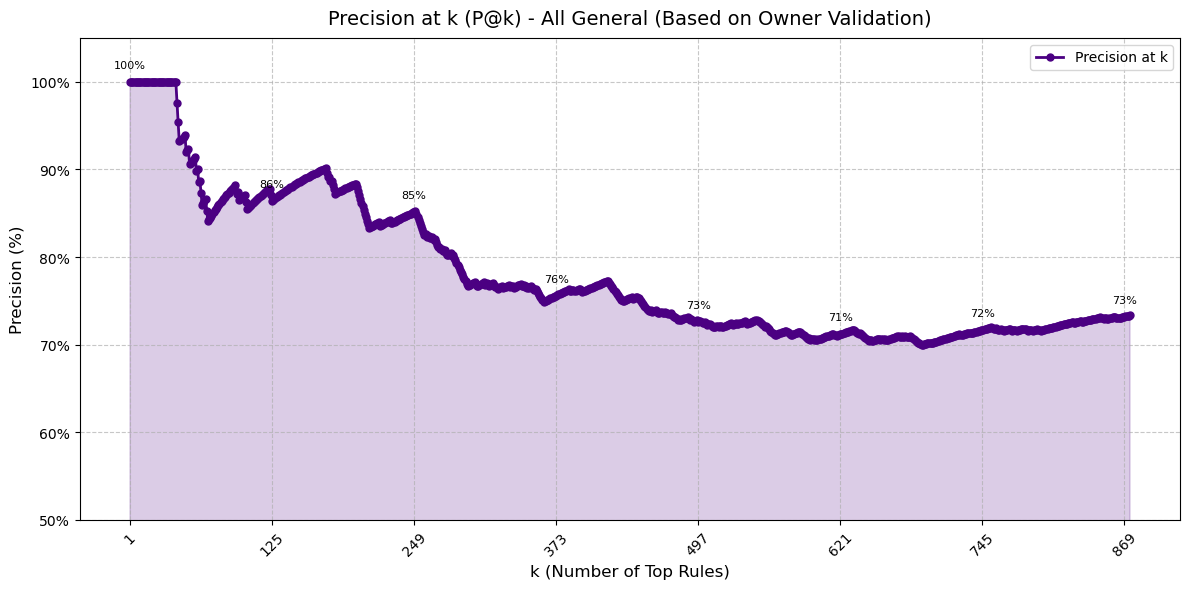

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_All_Products_Updated_Business_Logic.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")

    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - All General (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

## precision @ k shopee 

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'status', 'validity'],
      dtype='object')

Jumlah total baris: 806

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@81 = 1.00 (100%)
P@161 = 0.96 (96%)
P@241 = 0.95 (95%)
P@321 = 0.92 (92%)
P@401 = 0.92 (92%)
P@481 = 0.89 (89%)
P@561 = 0.89 (89%)
P@641 = 0.89 (89%)
P@721 = 0.90 (90%)
P@801 = 0.90 (90%)


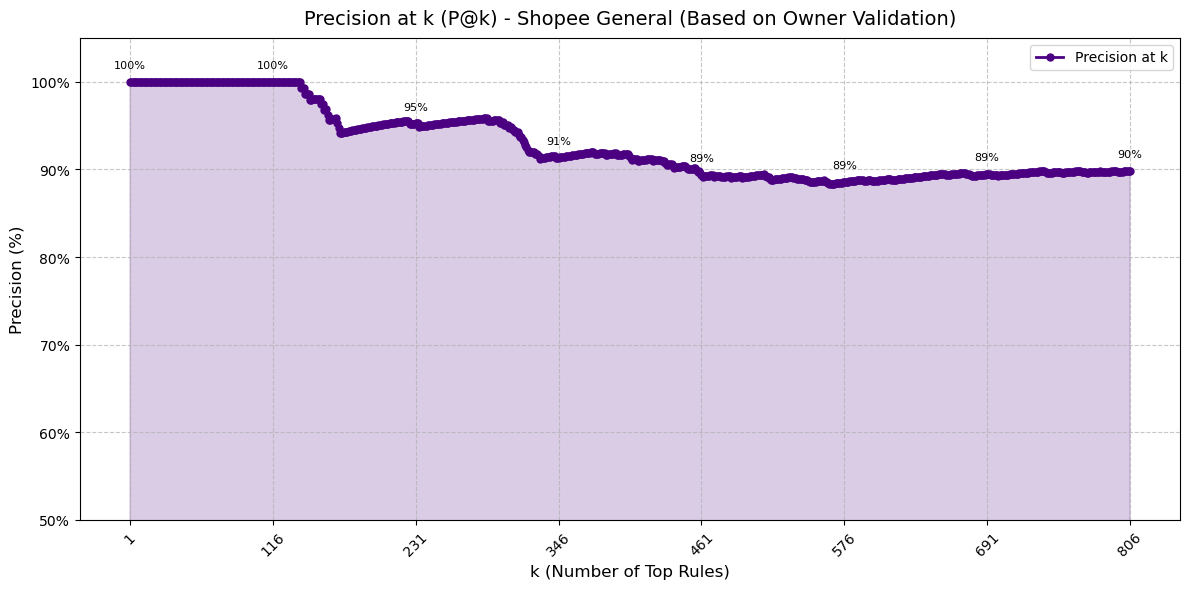

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Shopee_Products_Updated_Business_Logic.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")


    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - Shopee General (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

## precision @ k tokopedia

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'status', 'validity'],
      dtype='object')

Jumlah total baris: 1578

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@158 = 0.96 (96%)
P@315 = 0.92 (92%)
P@472 = 0.91 (91%)
P@629 = 0.90 (90%)
P@786 = 0.89 (89%)
P@943 = 0.89 (89%)
P@1100 = 0.87 (87%)
P@1257 = 0.88 (88%)
P@1414 = 0.88 (88%)
P@1571 = 0.88 (88%)


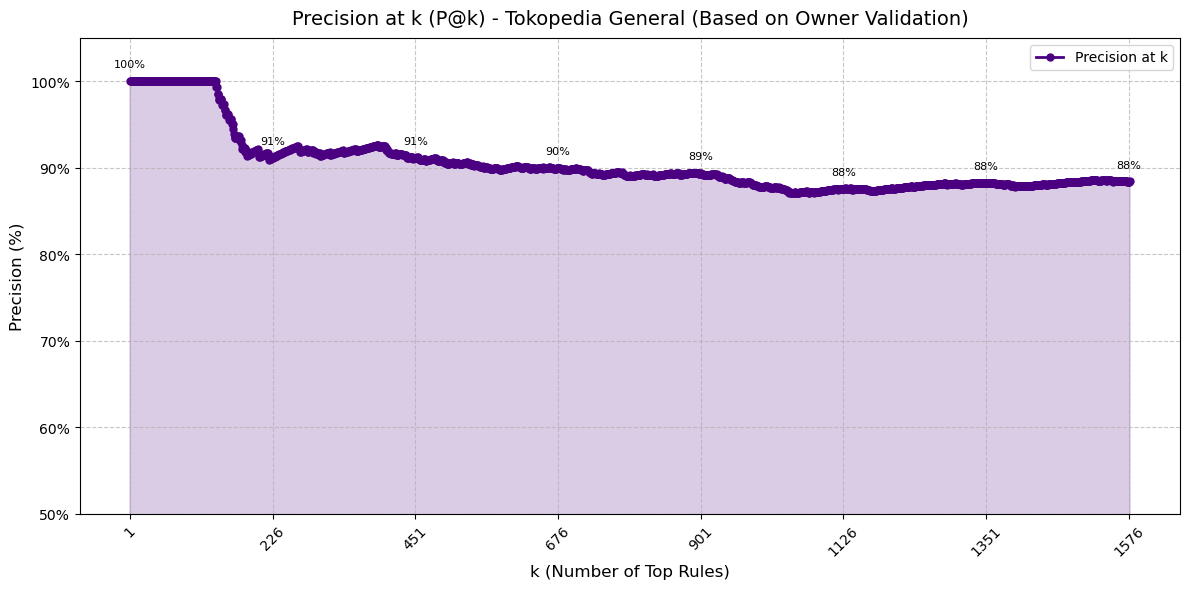

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Tokopedia_Products_Updated_Business_Logic.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")

    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - Tokopedia General (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

## precision @ k lazada

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'status', 'validity'],
      dtype='object')

Jumlah total baris: 359

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@36 = 1.00 (100%)
P@71 = 1.00 (100%)
P@106 = 1.00 (100%)
P@141 = 0.94 (94%)
P@176 = 0.95 (95%)
P@211 = 0.95 (95%)
P@246 = 0.96 (96%)
P@281 = 0.96 (96%)
P@316 = 0.96 (96%)
P@351 = 0.96 (96%)


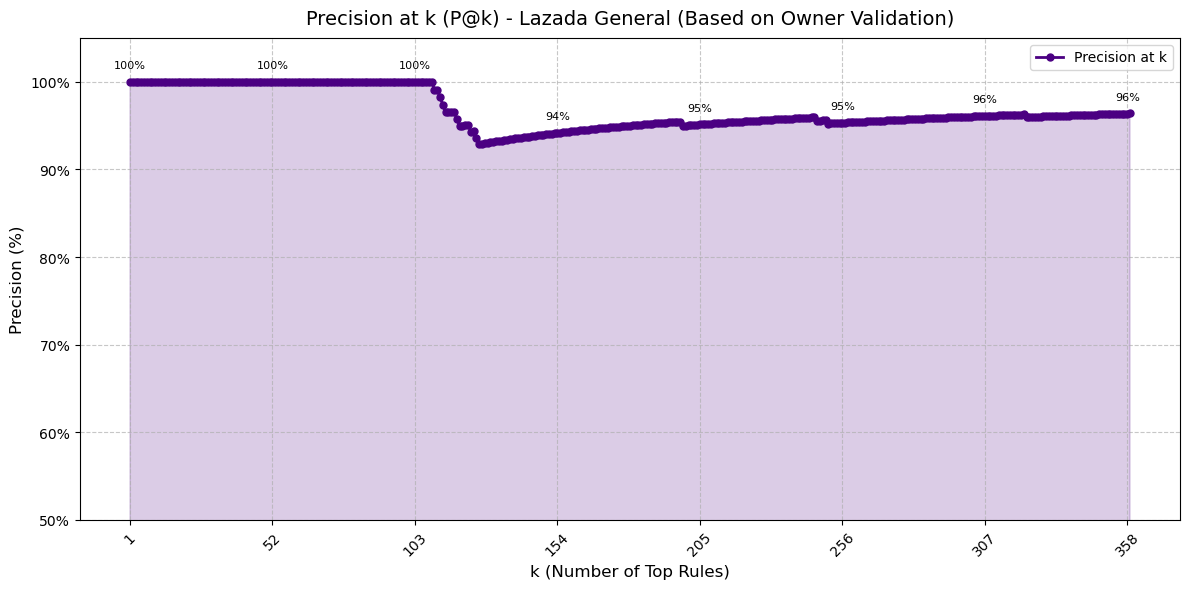

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Lazada_Products_Updated_Business_Logic.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")

    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - Lazada General (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

## precision @ k general ds

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'Antecedent_Category', 'Consequent_Category', 'status', 'validity'],
      dtype='object')

Jumlah total baris: 919

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@92 = 1.00 (100%)
P@183 = 0.97 (97%)
P@274 = 0.79 (79%)
P@365 = 0.76 (76%)
P@456 = 0.74 (74%)
P@547 = 0.74 (74%)
P@638 = 0.73 (73%)
P@729 = 0.72 (72%)
P@820 = 0.71 (71%)
P@911 = 0.71 (71%)


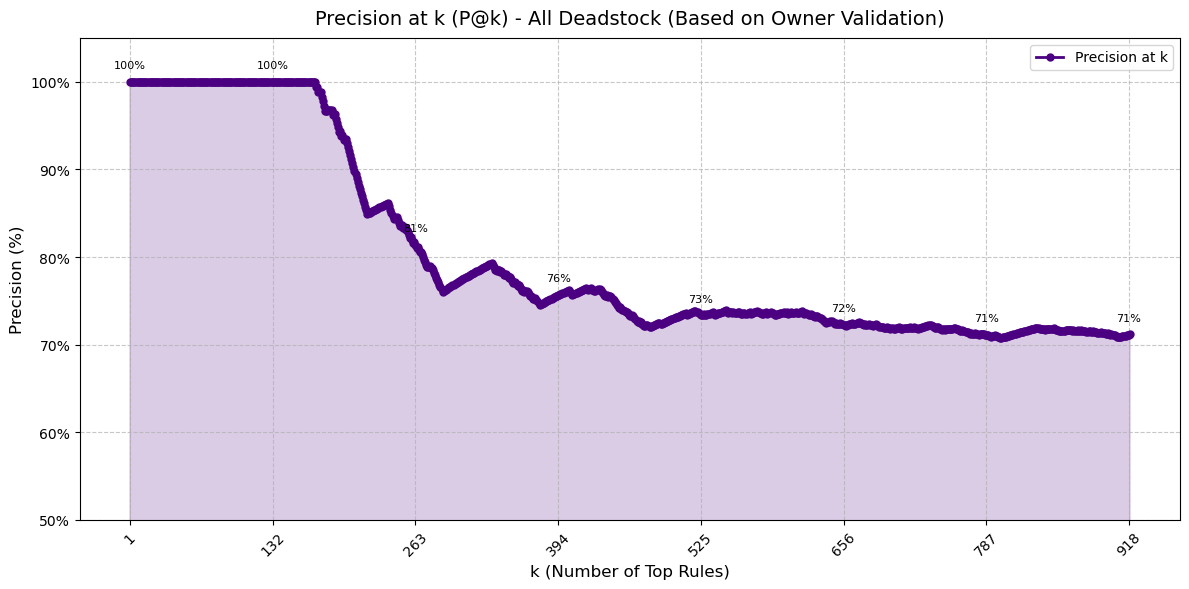

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Deadstock_Final_Updated_Business_Logic.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")


    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - All Deadstock (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

## precision @ k shopee ds

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'Antecedent_Category', 'Consequent_Category', 'status', 'validity'],
      dtype='object')

Jumlah total baris: 1216

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@122 = 0.98 (98%)
P@243 = 0.98 (98%)
P@364 = 0.98 (98%)
P@485 = 0.98 (98%)
P@606 = 0.99 (99%)
P@727 = 0.98 (98%)
P@848 = 0.98 (98%)
P@969 = 0.99 (99%)
P@1090 = 0.99 (99%)
P@1211 = 0.99 (99%)


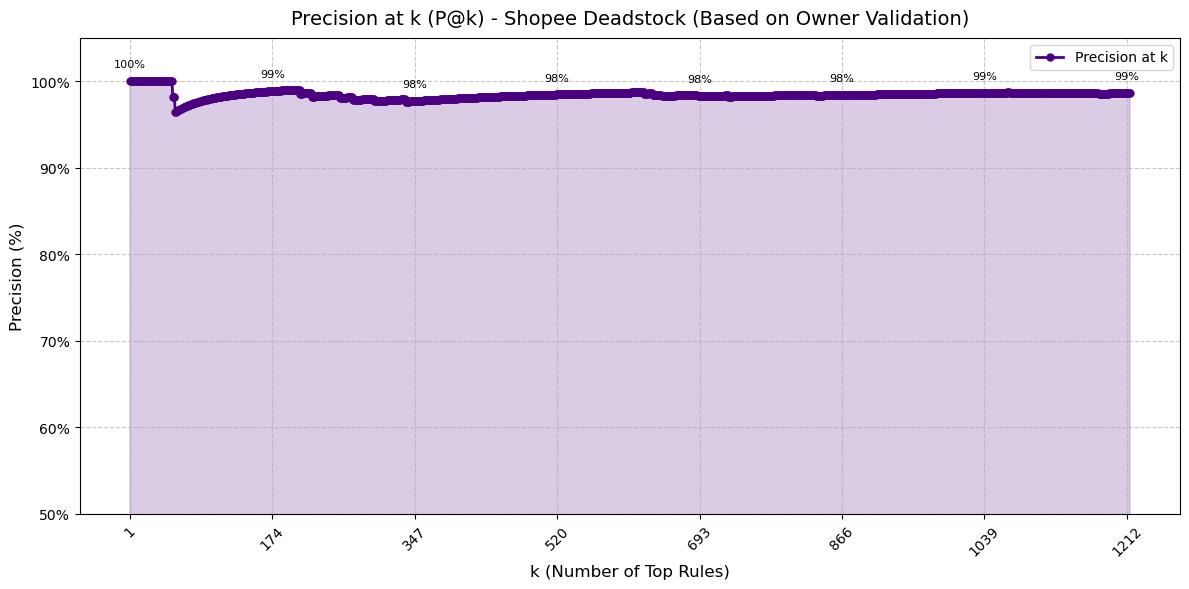

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Shopee_Deadstock_Final_Updated_Business_Logic.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")

    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - Shopee Deadstock (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'Antecedent_Category', 'Consequent_Category', 'status', 'validity'],
      dtype='object')

Jumlah total baris: 432

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@44 = 0.95 (95%)
P@87 = 0.83 (83%)
P@130 = 0.83 (83%)
P@173 = 0.87 (87%)
P@216 = 0.88 (88%)
P@259 = 0.90 (90%)
P@302 = 0.91 (91%)
P@345 = 0.92 (92%)
P@388 = 0.93 (93%)
P@431 = 0.94 (94%)


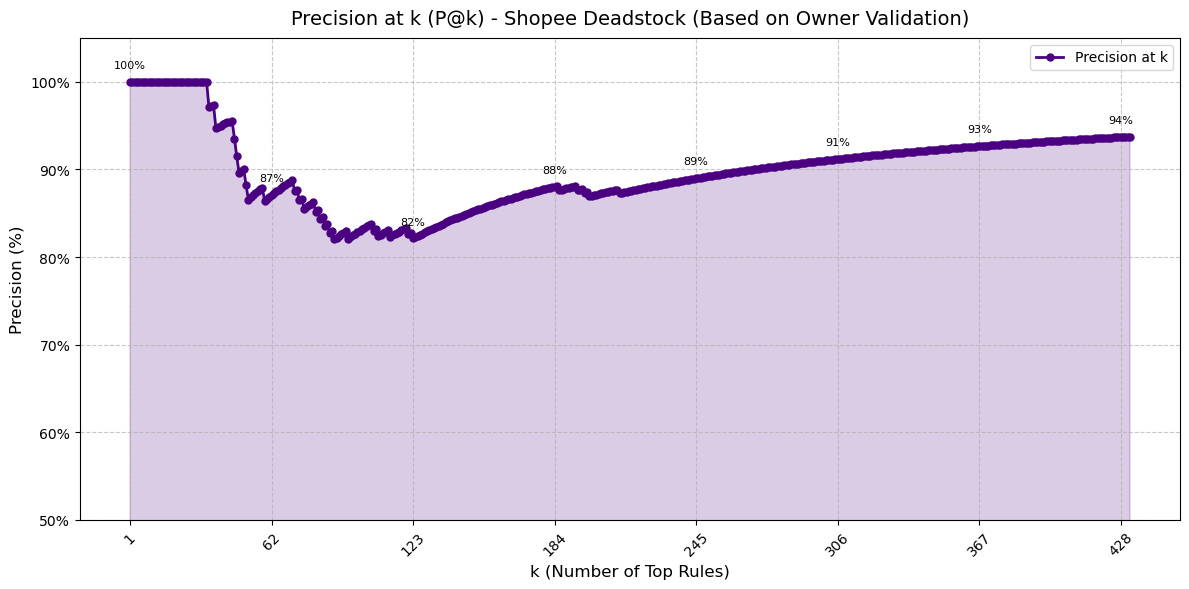

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Shopee_Deadstock_Final_Updated_Business_Logic2.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")

    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - Shopee Deadstock (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

## precision @ k tokopedia ds

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'Antecedent_Category', 'Consequent_Category', 'status', 'validity'],
      dtype='object')

Jumlah total baris: 403

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@41 = 1.00 (100%)
P@81 = 1.00 (100%)
P@121 = 0.98 (98%)
P@161 = 0.93 (93%)
P@201 = 0.92 (92%)
P@241 = 0.91 (91%)
P@281 = 0.90 (90%)
P@321 = 0.89 (89%)
P@361 = 0.88 (88%)
P@401 = 0.87 (87%)


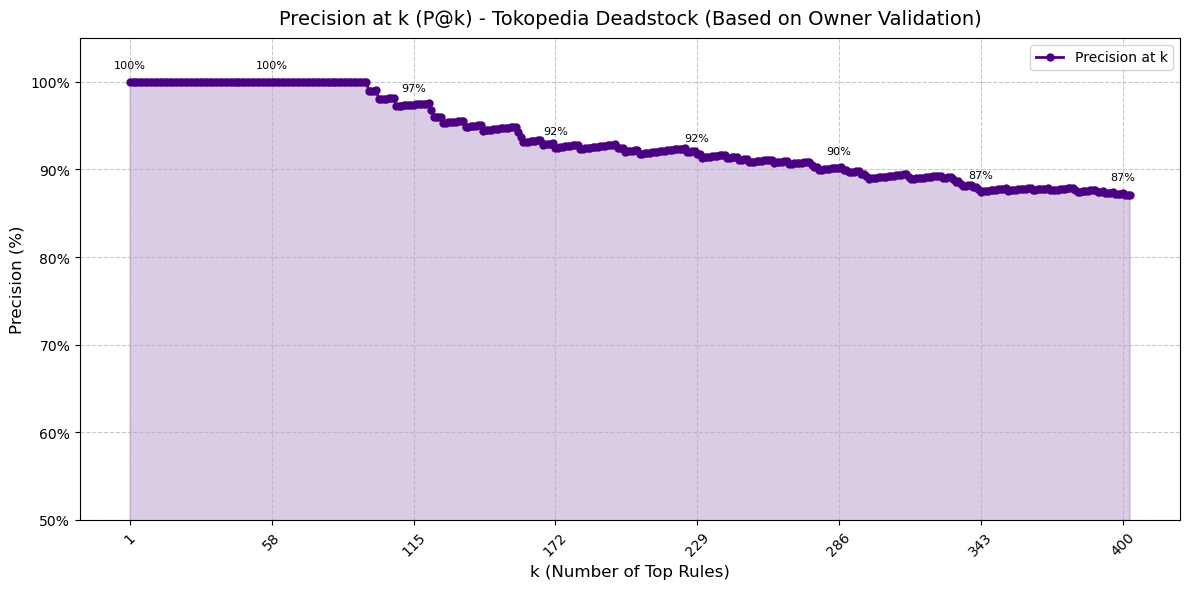

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Tokopedia_Deadstock_Final_Updated_Business_Logic.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")

    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - Tokopedia Deadstock (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'Antecedent_Category', 'Consequent_Category', 'status', 'validity'],
      dtype='object')

Jumlah total baris: 241

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@25 = 1.00 (100%)
P@49 = 1.00 (100%)
P@73 = 0.95 (95%)
P@97 = 0.96 (96%)
P@121 = 0.93 (93%)
P@145 = 0.93 (93%)
P@169 = 0.91 (91%)
P@193 = 0.89 (89%)
P@217 = 0.88 (88%)
P@241 = 0.86 (86%)


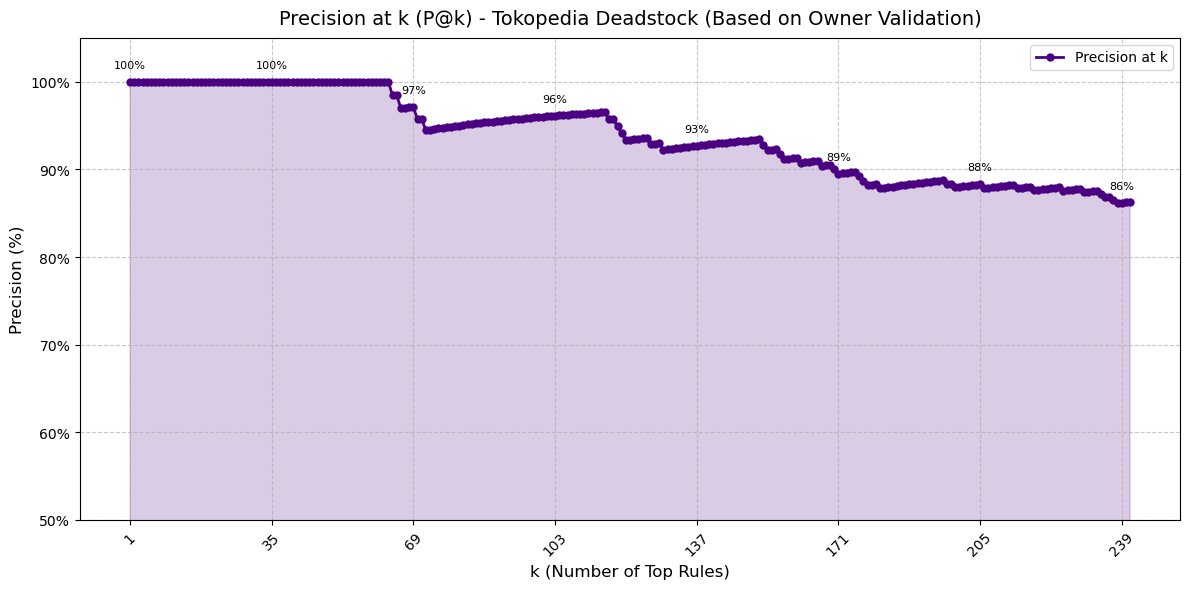

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Tokopedia_Deadstock_Final_Updated_Business_Logic2.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")

    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - Tokopedia Deadstock (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

## precision @ k lazada ds

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'Antecedent_Category', 'Consequent_Category', 'status', 'validity'],
      dtype='object')

Jumlah total baris: 262

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@27 = 1.00 (100%)
P@53 = 1.00 (100%)
P@79 = 1.00 (100%)
P@105 = 1.00 (100%)
P@131 = 1.00 (100%)
P@157 = 1.00 (100%)
P@183 = 1.00 (100%)
P@209 = 1.00 (100%)
P@235 = 1.00 (100%)
P@261 = 1.00 (100%)


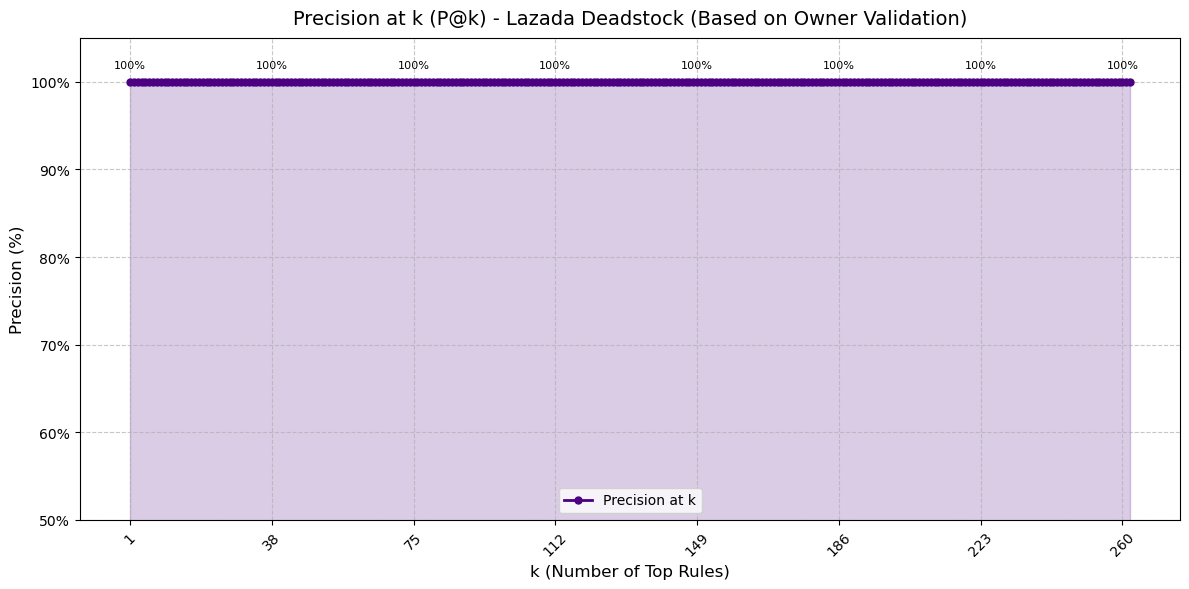

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Lazada_Deadstock_Final_Updated_Business_Logic.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")

    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - Lazada Deadstock (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

Kolom yang tersedia di DataFrame:
Index(['sheet', 'antecedent', 'consequent', 'confidence', 'lift', 'support',
       'Antecedent_Category', 'Consequent_Category', 'status', 'validity'],
      dtype='object')

Jumlah total baris: 284

Hasil Precision at k (P@k):
P@1 = 1.00 (100%)
P@29 = 1.00 (100%)
P@57 = 0.96 (96%)
P@85 = 0.89 (89%)
P@113 = 0.92 (92%)
P@141 = 0.92 (92%)
P@169 = 0.93 (93%)
P@197 = 0.94 (94%)
P@225 = 0.95 (95%)
P@253 = 0.96 (96%)
P@281 = 0.96 (96%)


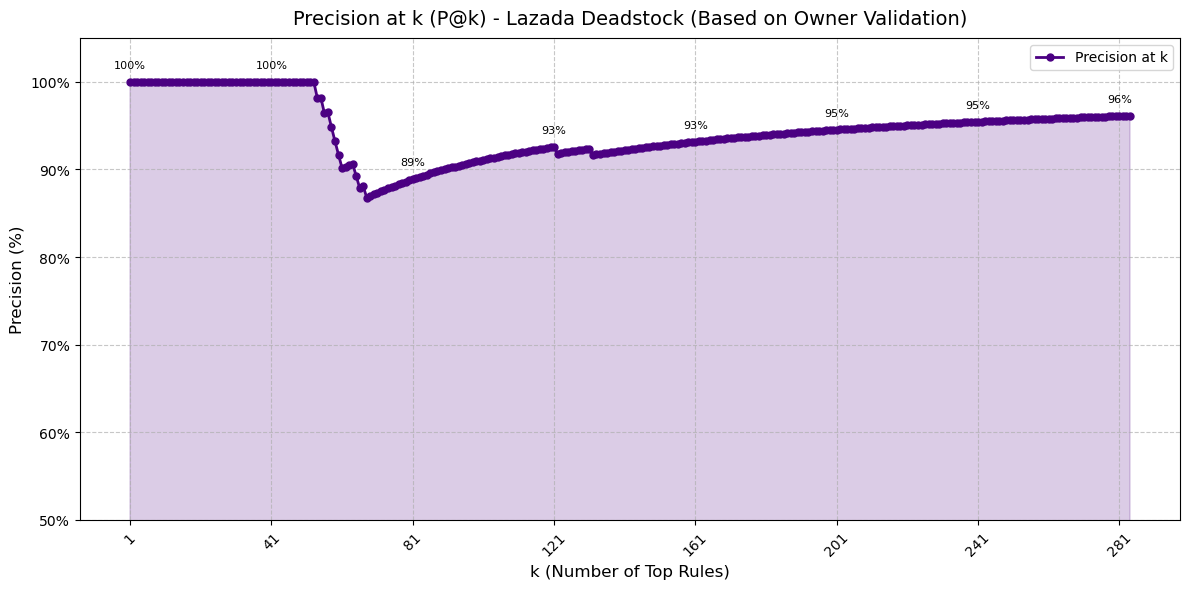

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Fungsi untuk membaca file Excel dan menangani error
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path dan nama file benar.")
        return None
    except ValueError as e:
        print(f"Error: Sheet '{sheet_name}' tidak ditemukan atau file rusak. {e}")
        return None

# Path file dan nama sheet
file_path = 'FP_Growth_Lazada_Deadstock_Final_Updated_Business_Logic2.xlsx'
sheet_name = 'All_Rules_With_Status'

# Membaca file Excel
df = load_data(file_path, sheet_name)

# Jika data berhasil dimuat
if df is not None:
    # Menampilkan kolom yang tersedia
    print("Kolom yang tersedia di DataFrame:")
    print(df.columns)

    # Mengurutkan data berdasarkan kolom 'support' secara menurun
    df_sorted = df.sort_values(by='support', ascending=False)

    # Mengambil kolom 'valid' yang sudah ada
    valid_data = df_sorted['validity'].tolist()
    total_rows = len(valid_data)
    print(f"\nJumlah total baris: {total_rows}")

    # Fungsi untuk menghitung Precision at k
    def precision_at_k(valid_data, k):
        if k > len(valid_data):
            k = len(valid_data)
        valid_count = sum(valid_data[:k])  # Jumlah item valid dalam k item teratas
        return valid_count / k if k > 0 else 0

    # Menghitung P@k untuk setiap k dari 1 hingga jumlah total baris
    k_values = list(range(1, total_rows + 1))
    precisions = [precision_at_k(valid_data, k) for k in k_values]

    # Mencetak hasil P@k untuk beberapa titik
    print("\nHasil Precision at k (P@k):")
    step = max(1, total_rows // 10)  # Langkah untuk mencetak, maksimum 10 titik
    for k, p in zip(k_values[::step], precisions[::step]):
        print(f"P@{k} = {p:.2f} ({p*100:.0f}%)")

    # Membuat plot dengan perbaikan visual
    plt.figure(figsize=(12, 6))  # Ukuran plot lebih besar untuk kejelasan
    plt.plot(k_values, precisions, marker='o', linestyle='-', color='#4B0082', label='Precision at k', markersize=5, linewidth=2)
    plt.fill_between(k_values, precisions, color=(0.294, 0.0, 0.509, 0.2))  # Area fill dengan transparansi

    # Menambahkan label pada titik penting
    step_labels = max(1, total_rows // 7)  # Sekitar 7-8 titik label
    for k, p in zip(k_values[::step_labels], precisions[::step_labels]):
        plt.annotate(f'{p*100:.0f}%', (k, p), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    plt.title('Precision at k (P@k) - Lazada Deadstock (Based on Owner Validation)', fontsize=14, pad=10)
    plt.xlabel('k (Number of Top Rules)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(k_values[::step_labels], rotation=45 if total_rows > 50 else 0)  # Rotasi label jika banyak data

    # Mengatur sumbu y dalam format persen
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(0.5, 1.05)  # Rentang sumbu y dari 0.5 (50%) hingga 1.05 (105%)
    plt.tight_layout()  # Mengatur layout agar tidak overlap

    # Menyimpan plot ke file dengan DPI lebih tinggi untuk kualitas
    plt.show()
else:
    print("Proses dihentikan karena error dalam memuat data.")

## Chart Perbandingan All 

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_6216\2467136719.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


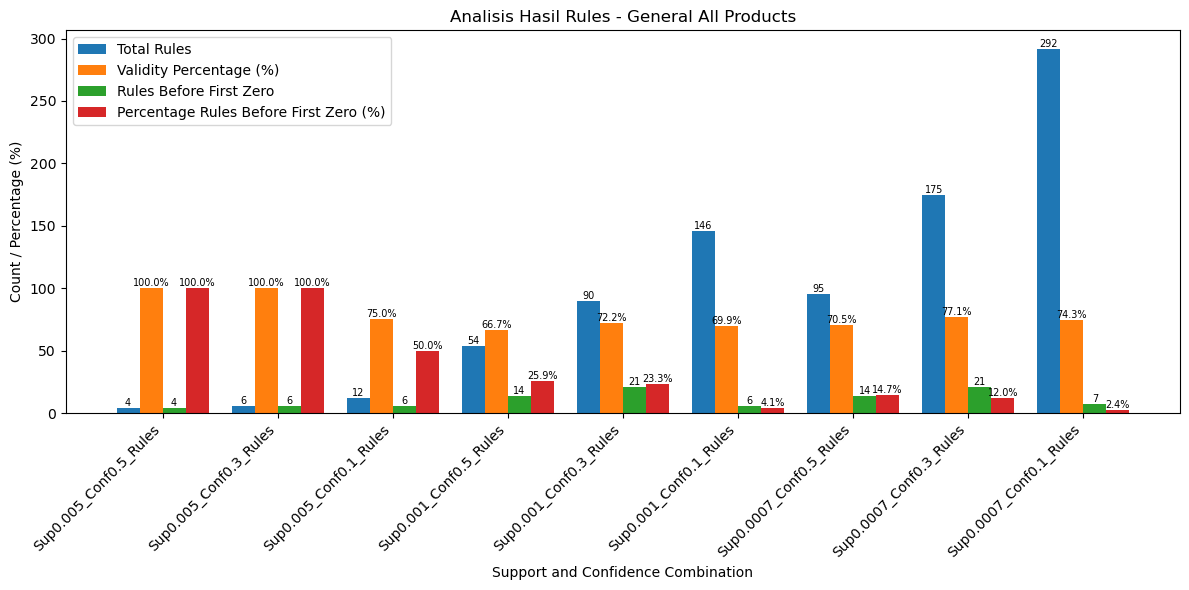

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_All_Products_Updated_Business_Logic.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - General All Products')
fig.tight_layout()
plt.show()

## Chart perbandingan shopee

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_6216\1526039833.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


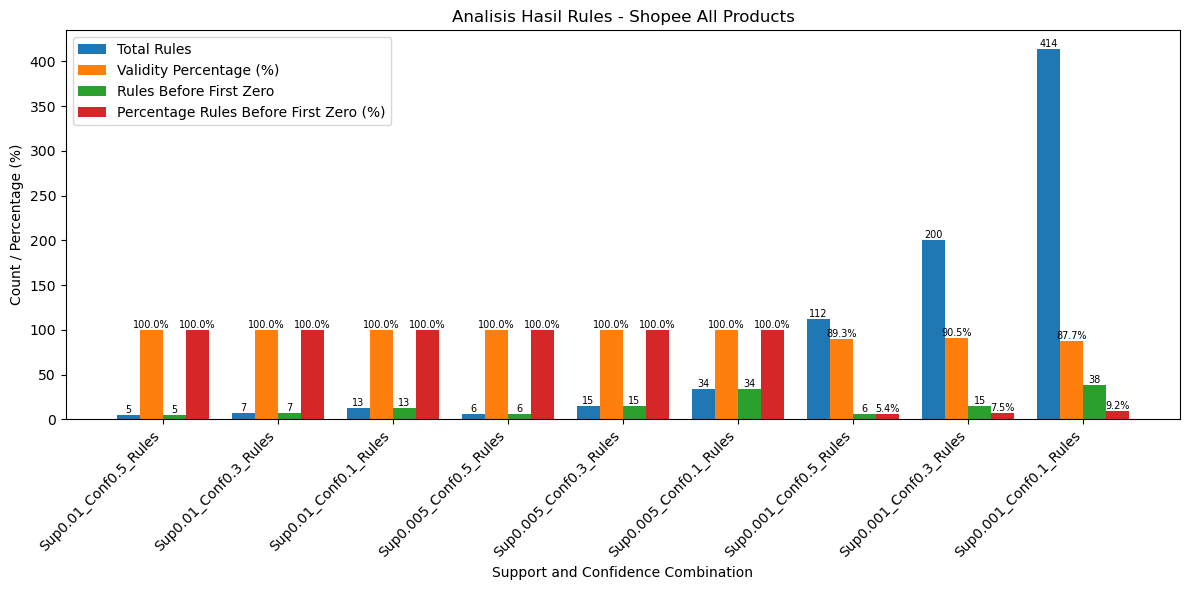

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Shopee_Products_Updated_Business_Logic.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - Shopee All Products')
fig.tight_layout()
plt.show()

## Chart perbandingan tokopedia

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_6216\3676670971.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


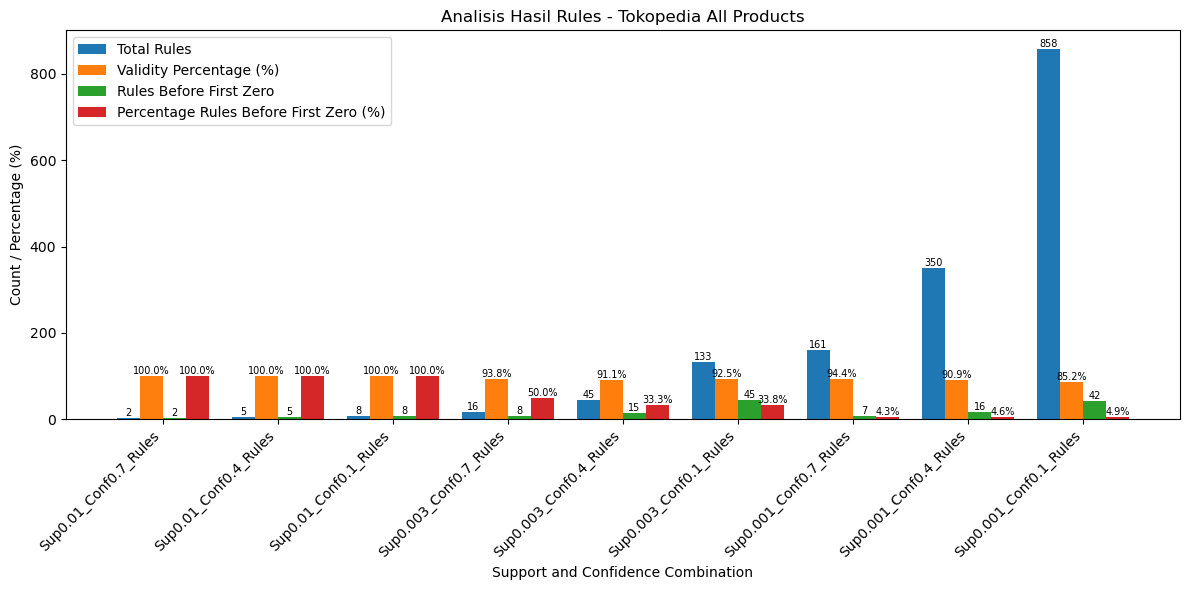

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Tokopedia_Products_Updated_Business_Logic.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - Tokopedia All Products')
fig.tight_layout()
plt.show()

## Chart perbandingan lazada

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_6216\3945647812.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


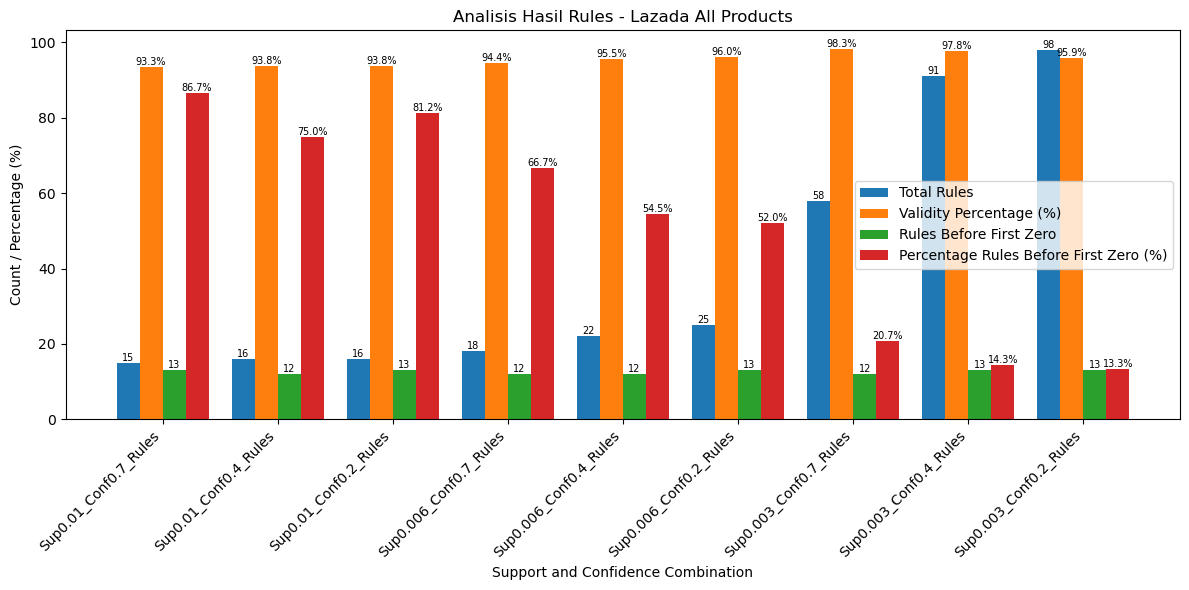

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Lazada_Products_Updated_Business_Logic.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - Lazada All Products')
fig.tight_layout()
plt.show()

## Chart perbandingan All DS

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_6216\1783795226.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


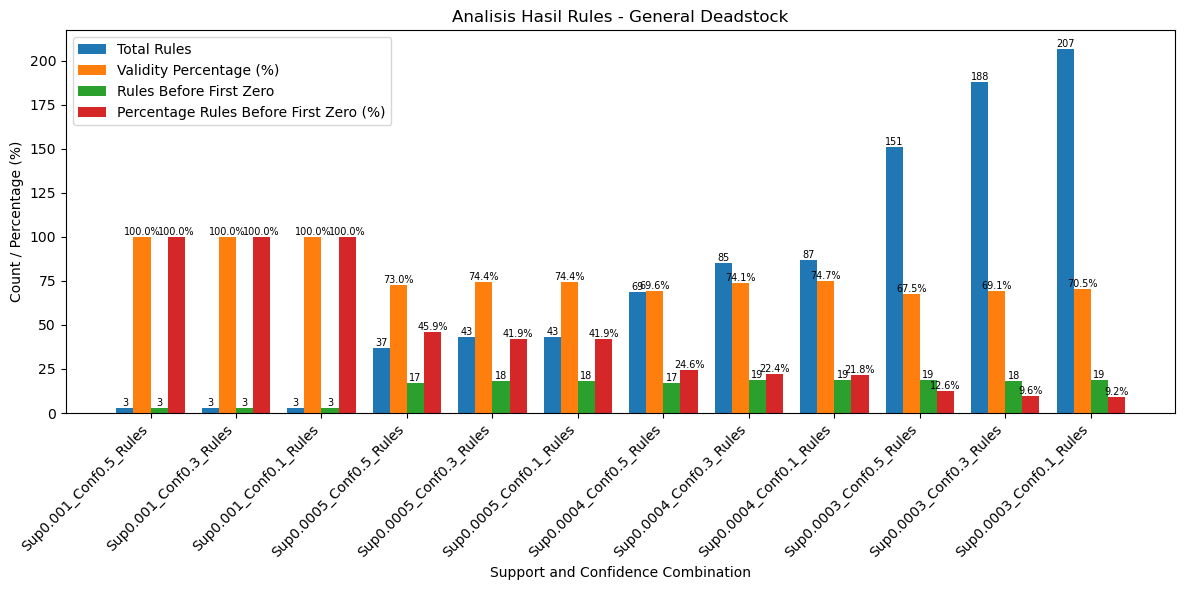

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Deadstock_Final_Updated_Business_Logic.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - General Deadstock')
fig.tight_layout()
plt.show()

## Chart perbandingan shopee DS

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_6216\2972736174.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


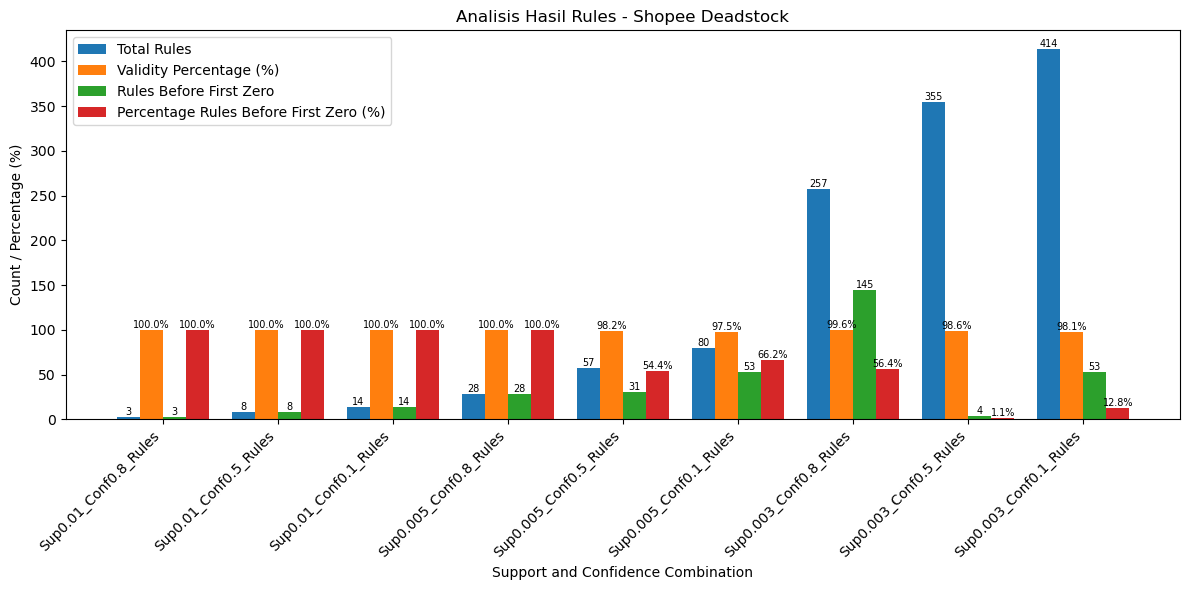

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Shopee_Deadstock_Final_Updated_Business_Logic.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - Shopee Deadstock')
fig.tight_layout()
plt.show()

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_16900\2123929455.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


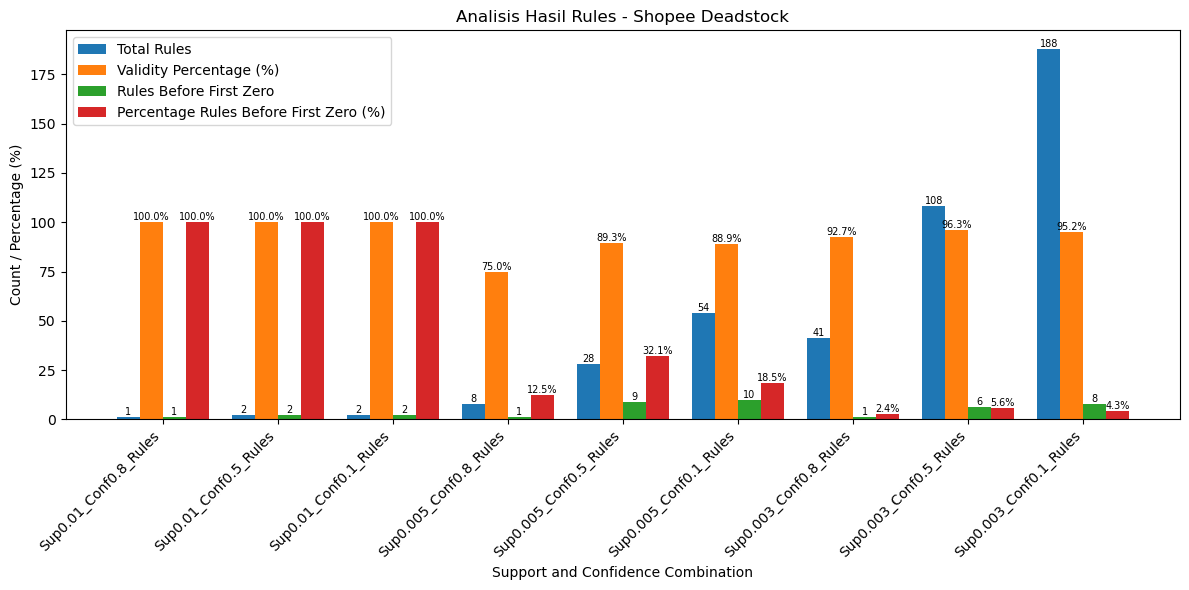

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Shopee_Deadstock_Final_Updated_Business_Logic2.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - Shopee Deadstock')
fig.tight_layout()
plt.show()

## Chart perbandingan tokopedia DS

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_6216\1628009848.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


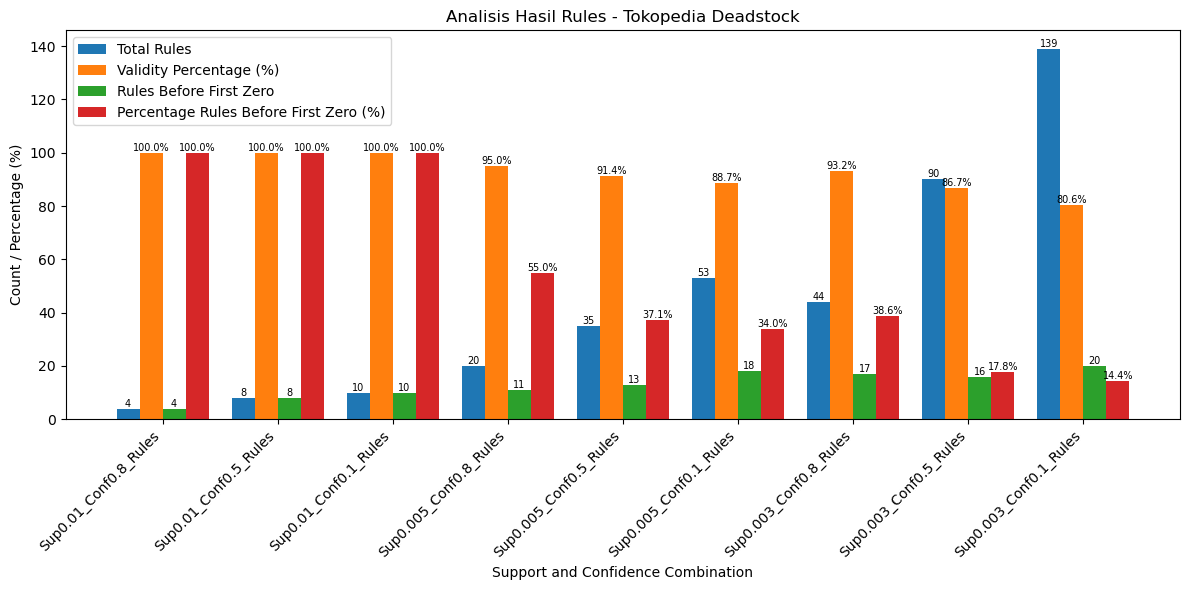

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Tokopedia_Deadstock_Final_Updated_Business_Logic.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - Tokopedia Deadstock')
fig.tight_layout()
plt.show()

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_16900\2627553466.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


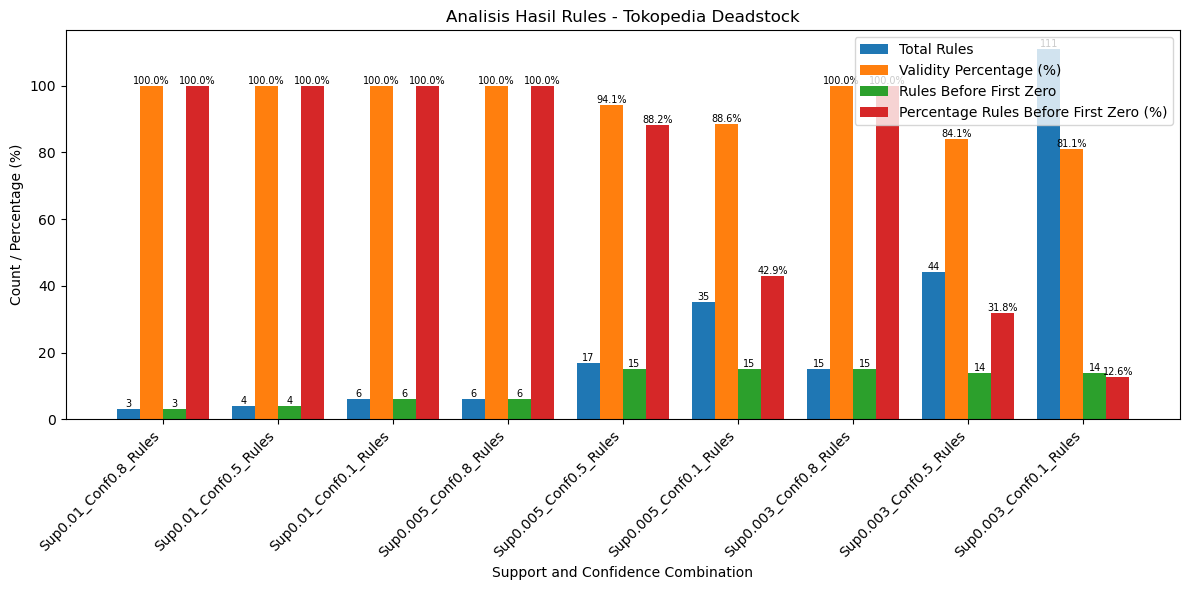

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Tokopedia_Deadstock_Final_Updated_Business_Logic2.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - Tokopedia Deadstock')
fig.tight_layout()
plt.show()

## Chart perbandingan lazada DS

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_6216\1556805262.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


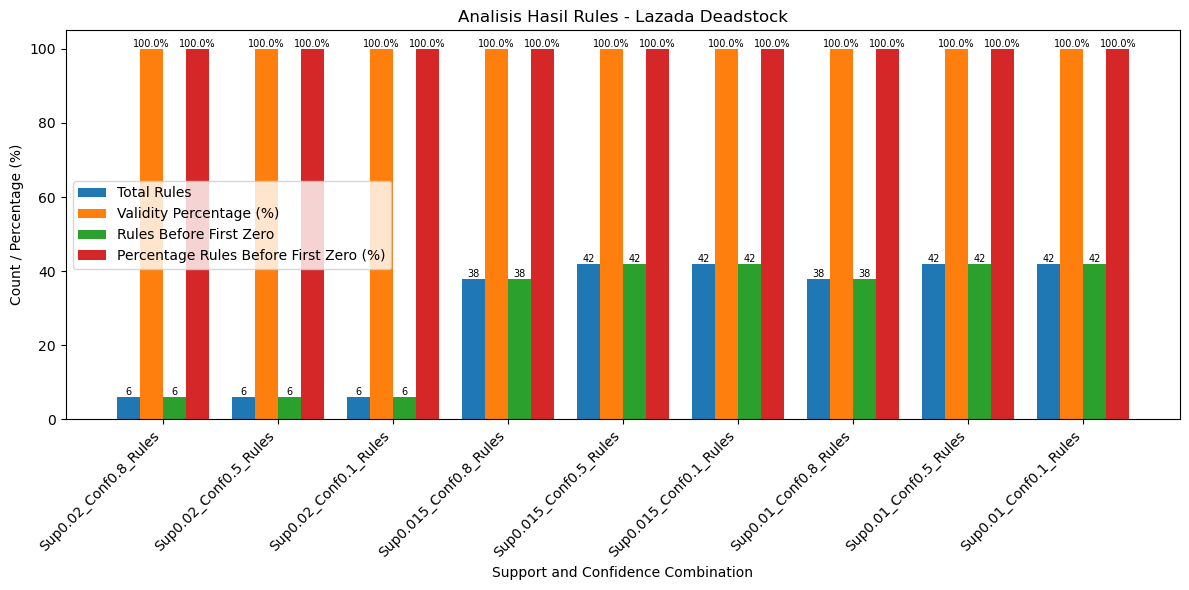

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Lazada_Deadstock_Final_Updated_Business_Logic.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - Lazada Deadstock')
fig.tight_layout()
plt.show()

C:\Users\Kent Maynard\AppData\Local\Temp\ipykernel_22748\2558399432.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')


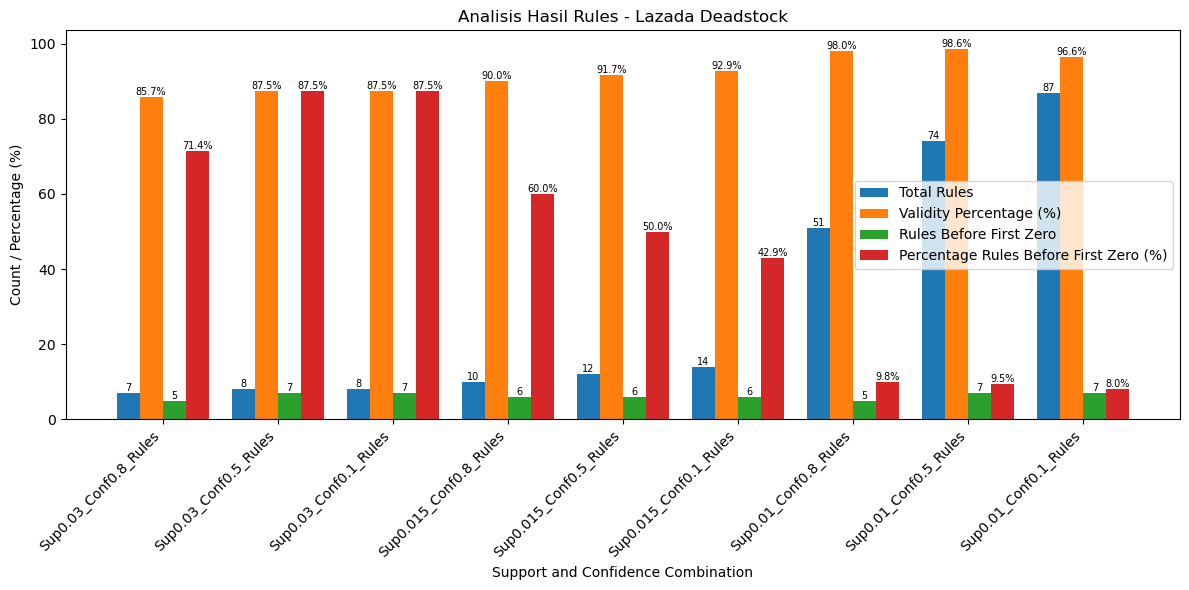

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Excel file and read the All_Rules_With_Status sheet
try:
    file_path = "FP_Growth_Lazada_Deadstock_Final_Updated_Business_Logic2.xlsx"
    df = pd.read_excel(file_path, sheet_name="All_Rules_With_Status")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except ValueError:
    print("Error: Sheet 'All_Rules_With_Status' not found in the Excel file.")
    exit()

# Pastikan kolom 'validity' dan 'support' dibaca sebagai numerik
df['validity'] = df['validity'].astype(int)
df['support'] = df['support'].astype(float)  # Kolom support ada di Excel (kolom C)

# Langkah 1: Sort DataFrame keseluruhan berdasarkan support tertinggi
df = df.sort_values(by='support', ascending=False)

# Langkah 2 dan 3: Hitung Rules Before First Zero per sheet dengan sort berdasarkan support
def calculate_rules_before_first_zero(group):
    # Urutkan berdasarkan support dalam setiap sheet (dari tertinggi ke terendah)
    group = group.sort_values(by='support', ascending=False)
    rules_before_zero = 0
    for val in group['validity']:
        if val == 0:  # Cek loop sampai ketemu 0 di break
            break
        if val == 1:  # Jika skornya 1, rules_before_zero + 1
            rules_before_zero += 1
    return rules_before_zero

# Terapkan perhitungan
grouped = df.groupby('sheet').apply(calculate_rules_before_first_zero).reset_index(name='rules_before_first_zero')

# Tambahkan Total Rules dan Valid Rules untuk konteks
grouped['total_rules'] = df.groupby('sheet').size().reset_index(name='count')['count']
grouped['valid_rules'] = df.groupby('sheet')['validity'].sum().reset_index(name='valid')['valid']
grouped['validity_percentage'] = (grouped['valid_rules'] / grouped['total_rules']) * 100

# Tambahkan kolom baru untuk persentase Rules Before First Zero
grouped['percentage_rules_before_zero'] = (grouped['rules_before_first_zero'] / grouped['total_rules']) * 100

# Extract support and confidence for sorting (jika perlu)
grouped['support'] = grouped['sheet'].str.extract(r'Sup(\d+\.?\d*)')[0].astype(float)
grouped['confidence'] = grouped['sheet'].str.extract(r'Conf(\d+\.?\d*)')[0].astype(float)
grouped = grouped.sort_values(by=['support', 'confidence'], ascending=[False, False]).drop(columns=['support', 'confidence'])

# 4. Create the visualization with side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouped['sheet']))
width = 0.2  # Lebar bar dikurangi karena ada 4 bar

# Bar 1: Total Rules
bars1 = ax.bar(x - 1.5 * width, grouped['total_rules'], width, label='Total Rules', color='#1f77b4')
# Bar 2: Validity Percentage
bars2 = ax.bar(x - 0.5 * width, grouped['validity_percentage'], width, label='Validity Percentage (%)', color='#ff7f0e')
# Bar 3: Rules Before First Zero
bars3 = ax.bar(x + 0.5 * width, grouped['rules_before_first_zero'], width, label='Rules Before First Zero', color='#2ca02c')
# Bar 4: Percentage Rules Before First Zero
bars4 = ax.bar(x + 1.5 * width, grouped['percentage_rules_before_zero'], width, label='Percentage Rules Before First Zero (%)', color='#d62728')

# Customize the plot
ax.set_xlabel('Support and Confidence Combination')
ax.set_ylabel('Count / Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(grouped['sheet'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of the bars with smaller font size
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=7)

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.title('Analisis Hasil Rules - Lazada Deadstock')
fig.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load file
file_path = "dataset/Combined_Penjualan.xlsx"
df = pd.read_excel(file_path)

# Pastikan kolom yang digunakan ada dalam DataFrame
if "Kode Nota" not in df.columns:
    raise ValueError("Kolom 'Kode Nota' tidak ditemukan dalam dataset!")

# Hitung jumlah kemunculan setiap transaksi (Kode Nota)
transaction_counts = df["Kode Nota"].value_counts()

# Ambil hanya transaksi dengan lebih dari 1 produk
multi_item_transactions = transaction_counts[transaction_counts > 1].index
combined_penjualan2 = df[df["Kode Nota"].isin(multi_item_transactions)]

# Simpan hasil ke file baru
output_file = "dataset/Combined_Penjualan2.xlsx"
combined_penjualan2.to_excel(output_file, index=False)
print(f"File combined_penjualan2 telah disimpan di {output_file}")

File combined_penjualan2 telah disimpan di dataset/Combined_Penjualan2.xlsx


In [ ]:
import pandas as pd
from collections import defaultdict

# Membaca file Excel
file_path = "dataset/combined_penjualan2.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Mengelompokkan produk berdasarkan "Kode Nota" sebagai set untuk mendapatkan kombinasi unik
kombinasi_per_transaksi = df.groupby("Kode Nota")["Deskripsi Brg"].apply(frozenset)

# Menggunakan set untuk mendapatkan pasangan unik dari transaksi
pasangan_unik = set(kombinasi_per_transaksi)

# Menghitung pasangan unik per produk
produk_ke_pasangan = defaultdict(set)
for pasangan in pasangan_unik:
    for produk in pasangan:
        produk_ke_pasangan[produk].add(pasangan)

# Menghitung jumlah pasangan unik per produk
jumlah_pasangan_per_produk = {produk: len(pasangan) for produk, pasangan in produk_ke_pasangan.items()}

# Menghitung kemunculan setiap produk dalam transaksi
kemunculan_produk = df["Deskripsi Brg"].value_counts().to_dict()

# Total jumlah transaksi
total_transaksi = df["Kode Nota"].nunique()

# Menggabungkan hasil ke dalam satu DataFrame
hasil_df = pd.DataFrame(list(jumlah_pasangan_per_produk.items()), columns=["Produk", "Jumlah Pasangan Unik"])
hasil_df["Kemunculan"] = hasil_df["Produk"].map(kemunculan_produk)

# Menghitung persentase kemunculan dari total transaksi
hasil_df["Persentase Kemunculan"] = (hasil_df["Kemunculan"] / total_transaksi) * 100

# Menyimpan hasil ke file Excel (XLSX)
output_xlsx = "dataset/frekuensi_produk.xlsx"
hasil_df.to_excel(output_xlsx, index=False)

# Menampilkan path file output
print(f"File hasil disimpan di: {output_xlsx}")

File hasil disimpan di: dataset/frekuensi_produk.xlsx


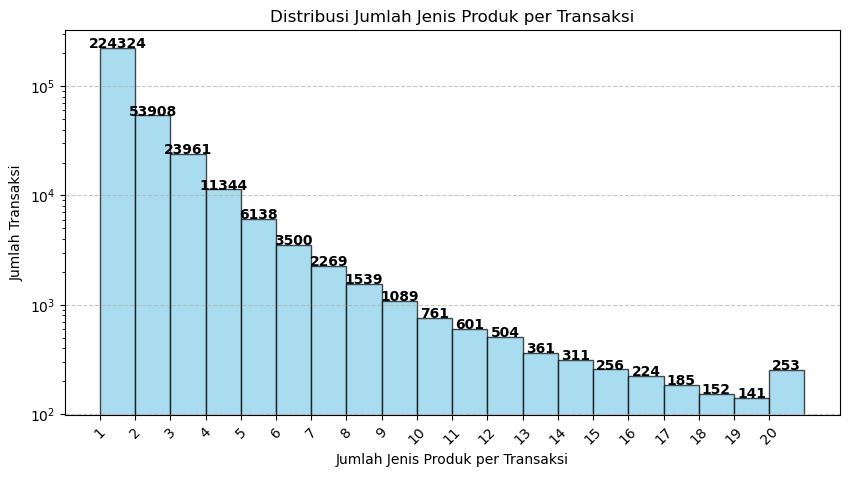

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
file_path = "dataset/Combined_Penjualan.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Hitung jumlah jenis produk unik per transaksi (Kode Nota)
produk_unik_per_transaksi = df.groupby("Kode Nota")["Deskripsi Brg"].nunique()

# Batasi rentang X untuk fokus pada data utama
max_x = min(20, max(produk_unik_per_transaksi))

# Plot histogram dengan skala log
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(produk_unik_per_transaksi, bins=range(1, max_x + 2), color='skyblue', edgecolor='black', alpha=0.7)

# Tambahkan angka di atas setiap bar
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:  # Hanya tampilkan angka jika ada data
        plt.text(bin_edge + 0.5, count, str(int(count)), ha='center', fontsize=10, fontweight='bold')

plt.xlabel("Jumlah Jenis Produk per Transaksi")
plt.ylabel("Jumlah Transaksi")
plt.title("Distribusi Jumlah Jenis Produk per Transaksi")
plt.xticks(range(1, max_x + 1), rotation=45)
plt.yscale("log")  # Log scale untuk distribusi lebih jelas
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()



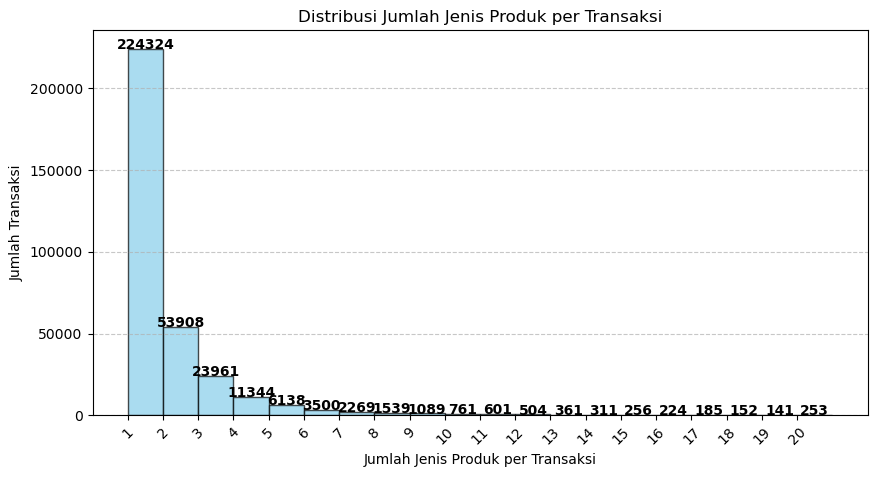

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
file_path = "dataset/Combined_Penjualan.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Hitung jumlah jenis produk unik per transaksi (Kode Nota)
produk_unik_per_transaksi = df.groupby("Kode Nota")["Deskripsi Brg"].nunique()

# Batasi rentang X untuk fokus pada data utama
max_x = min(20, max(produk_unik_per_transaksi))

# Plot histogram tanpa log scale
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(produk_unik_per_transaksi, bins=range(1, max_x + 2), color='skyblue', edgecolor='black', alpha=0.7)

# Tambahkan angka di atas setiap bar
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.5, count + 5, str(int(count)), ha='center', fontsize=10, fontweight='bold')

plt.xlabel("Jumlah Jenis Produk per Transaksi")
plt.ylabel("Jumlah Transaksi")
plt.title("Distribusi Jumlah Jenis Produk per Transaksi")
plt.xticks(range(1, max_x + 1), rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Grid untuk membantu membaca grafik
plt.show()



In [ ]:
for file in files:
    try:
        # Membaca data dari file
        df = pd.read_excel(file)
        
        # Memastikan kolom 'Kode Nota' ada
        if 'Kode Nota' in df.columns:
            # Menghitung jumlah untuk setiap Kode Nota
            kode_nota_counts = df['Kode Nota'].value_counts().reset_index()
            kode_nota_counts.columns = ['Kode Nota', 'Jumlah']

            # Menghitung jumlah kode nota dengan hasil 1, 2, dan lainnya
            jumlah_1 = kode_nota_counts[kode_nota_counts['Jumlah'] == 1].shape[0]
            jumlah_2 = kode_nota_counts[kode_nota_counts['Jumlah'] == 2].shape[0]
            jumlah_lainnya = kode_nota_counts[kode_nota_counts['Jumlah'] > 2].shape[0]
            persentase_1 = (jumlah_1) / (jumlah_1+jumlah_2+jumlah_lainnya) * 100
            persentase_2 = (jumlah_2) / (jumlah_1+jumlah_2+jumlah_lainnya) * 100
            persentase_lainnya = (jumlah_lainnya) / (jumlah_1+jumlah_2+jumlah_lainnya) * 100
            # Menampilkan hasil jumlah kode nota untuk file tertentu
            print(f"\nJumlah Kode Nota untuk {file}:")
            # print(kode_nota_counts)
            print(f"Jumlah dengan hasil 1: {jumlah_1}")
            print(f"Jumlah dengan hasil 2: {jumlah_2}")
            print(f"Jumlah lainnya (lebih dari 2): {jumlah_lainnya}")
            print(f"Persentase per kode nota hasil 1: {persentase_1}%")
            print(f"Persentase per kode nota hasil 2: {persentase_2}%")
            print(f"Persentase per kode nota hasil lainnya: {persentase_lainnya}%")
        else:
            print(f"\nKolom 'Kode Nota' tidak ditemukan di {file}.")

    except Exception as e:
        print(f"Error saat membaca file {file}: {e}")


Jumlah Kode Nota untuk dataset/Penjualan_Lazada_1.xlsx:
Jumlah dengan hasil 1: 4531
Jumlah dengan hasil 2: 249
Jumlah lainnya (lebih dari 2): 8
Persentase per kode nota hasil 1: 94.63241436925648%
Persentase per kode nota hasil 2: 5.200501253132832%
Persentase per kode nota hasil lainnya: 0.1670843776106934%

Jumlah Kode Nota untuk dataset/Penjualan_Lazada_2.xlsx:
Jumlah dengan hasil 1: 3987
Jumlah dengan hasil 2: 121
Jumlah lainnya (lebih dari 2): 45
Persentase per kode nota hasil 1: 96.00288947748615%
Persentase per kode nota hasil 2: 2.9135564652058754%
Persentase per kode nota hasil lainnya: 1.08355405730797%

Jumlah Kode Nota untuk dataset/Penjualan_Lazada_3.xlsx:
Jumlah dengan hasil 1: 451
Jumlah dengan hasil 2: 5
Jumlah lainnya (lebih dari 2): 0
Persentase per kode nota hasil 1: 98.90350877192982%
Persentase per kode nota hasil 2: 1.0964912280701753%
Persentase per kode nota hasil lainnya: 0.0%

Jumlah Kode Nota untuk dataset/Penjualan_Retail_NG.xlsx:
Jumlah dengan hasil 1: 400

In [ ]:
# Menyimpan semua data ke dalam DataFrame
all_data = []

# Looping setiap file untuk membaca dan mengumpulkan kode nota
for file in files:
    df = pd.read_excel(file)  # Membaca data dari setiap file
    all_data.append(df)

# Menggabungkan semua DataFrame menjadi satu
combined_df = pd.concat(all_data, ignore_index=True)

# Menghitung jumlah untuk setiap Kode Nota
kode_nota_counts = combined_df['Kode Nota'].value_counts().reset_index()
kode_nota_counts.columns = ['Kode Nota', 'Jumlah']

# Menghitung jumlah kode nota dengan hasil 1, 2, dan lainnya
jumlah_1 = kode_nota_counts[kode_nota_counts['Jumlah'] == 1].shape[0]
jumlah_2 = kode_nota_counts[kode_nota_counts['Jumlah'] == 2].shape[0]
jumlah_lainnya = kode_nota_counts[kode_nota_counts['Jumlah'] > 2].shape[0]

# Menampilkan hasil
print("Jumlah Kode Nota dengan jumlah 1, 2, dan lainnya:")
print(f"Jumlah 1: {jumlah_1}")
print(f"Jumlah 2: {jumlah_2}")
print(f"Jumlah lainnya (lebih dari 2): {jumlah_lainnya}")

Jumlah Kode Nota dengan jumlah 1, 2, dan lainnya:
Jumlah 1: 224180
Jumlah 2: 53951
Jumlah lainnya (lebih dari 2): 54684
